In [1]:
import json
import random
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def load_config(config_file):
    with open(config_file, 'r') as f:
        return json.load(f)

In [34]:
def generate_routine_graph(devices, actions_per_device, complex_dependencies=False, prob_multiple_children=0.5, non_completion_dependencies_ratio=0.5):
    """Generates a graph for a routine that includes multiple devices and actions per device."""
    G = nx.DiGraph()
    action_nodes = []

    # Add actions from all devices
    for device, actions in actions_per_device.items():
        device_actions = [f"{device}_{action}" for action in actions]
        action_nodes.extend(device_actions)
        G.add_nodes_from(device_actions)

    if complex_dependencies:
        for i in range(len(action_nodes) - 1):
            remaining_actions = len(action_nodes) - i - 1
            num_children = 1
            # Ensure there are enough remaining actions to create multiple children
            if random.random() < prob_multiple_children and remaining_actions > 1:
                num_children = random.randint(2, min(3, remaining_actions))  # Ensure we don't exceed remaining actions

            # Ensure no two actions on the same device can run at the same time
            for j in range(1, num_children + 1):
                action_device = action_nodes[i].split('_')[0]  # Extract device from action
                next_action_device = action_nodes[i + j].split('_')[0]  # Extract device from next action

                if action_device == next_action_device:
                    dependency_type = 'completion'  # Enforce completion-based dependency if same device
                else:
                    if random.random() < non_completion_dependencies_ratio:
                        dependency_type = random.choice(['acknowledgment', 'start'])
                    else:
                        dependency_type = 'completion'
                G.add_edge(action_nodes[i], action_nodes[i + j], dependency=dependency_type)
    else:
        for i in range(len(action_nodes) - 1):
            G.add_edge(action_nodes[i], action_nodes[i + 1], dependency='completion')

    return G

In [35]:
def generate_routines_for_space(smart_space, device_actions, scale_constraints, config_constraints):
    """Generates a routine graph for multiple devices and actions per device."""
    routine_graphs = {}
    total_routines = 0
    max_actions = scale_constraints.get("max_actions", 5)
    max_routines = scale_constraints.get("max_routines", 3)

    # Extract the configurable constraints from the config file
    use_complex_dependencies = config_constraints.get('use_complex_dependencies', True)
    prob_multiple_children = config_constraints.get('probability_multiple_children', 0.5)
    non_completion_dependencies_ratio = config_constraints.get('non_completion_dependencies_ratio', 0.5)
    high_action_routine_percentage = config_constraints.get('high_action_routine_percentage', 0.3)  # Default 30%

    required_high_action_routines = int(high_action_routine_percentage * max_routines)
    high_action_threshold = int(0.9 * max_actions)  # 90% of max_actions
    high_action_routines_count = 0

    for routine_id in range(max_routines):
        devices_in_routine = random.sample(list(smart_space["device_types"].keys()), random.randint(1, len(smart_space["device_types"])))
        actions_per_device = {}

        for device in devices_in_routine:
            available_actions = device_actions[device]
            num_actions = random.randint(1, min(len(available_actions), max_actions))
            actions_per_device[device] = random.sample(available_actions, num_actions)

        routine_graph = generate_routine_graph(
            devices_in_routine, actions_per_device,
            complex_dependencies=use_complex_dependencies,
            prob_multiple_children=prob_multiple_children,
            non_completion_dependencies_ratio=non_completion_dependencies_ratio
        )
        routine_graphs[f"routine_{routine_id}"] = routine_graph
        total_routines += 1

    return routine_graphs

In [23]:
def generate_routines_for_smart_spaces(config_file):
    """Generates a set of routine graphs for each smart space."""
    config = load_config(config_file)
    smart_spaces = config["smart_spaces"]
    device_actions = config["device_actions"]
    config_constraints = config.get("constraints", {})

    space_routines = {}

    for space_name, space_info in smart_spaces.items():
        routines = generate_routines_for_space(space_info, device_actions, space_info["scale_constraints"], config_constraints)
        space_routines[space_name] = routines

    return space_routines

In [24]:
def visualize_routine_graph(graph, device_name, space_name):
    """Visualizes the graph of a single device routine."""
    plt.figure(figsize=(6, 4))
    pos = nx.spring_layout(graph)
    edge_labels = nx.get_edge_attributes(graph, 'dependency')
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.title(f"Routine Graph for {device_name} in {space_name}")
    plt.show()

In [42]:
config_file = 'routines_config.json'
space_routines = generate_routines_for_smart_spaces(config_file)

Generated routines for apartment:
Routine for device: routine_0
['oven_broil', 'oven_bake', 'dryer_dry', 'thermostat_off', 'thermostat_cool', 'coffee_machine_mocha', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'washer_rinse', 'shade_up', 'dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse']


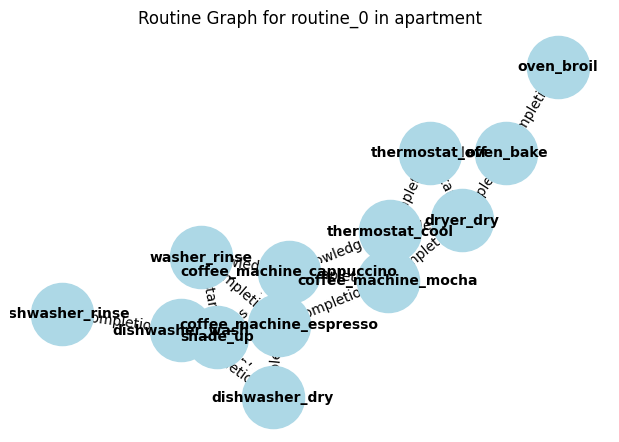

Routine for device: routine_1
['coffee_machine_mocha', 'coffee_machine_latte', 'coffee_machine_espresso', 'coffee_machine_americano', 'light_turn_on', 'shade_up']


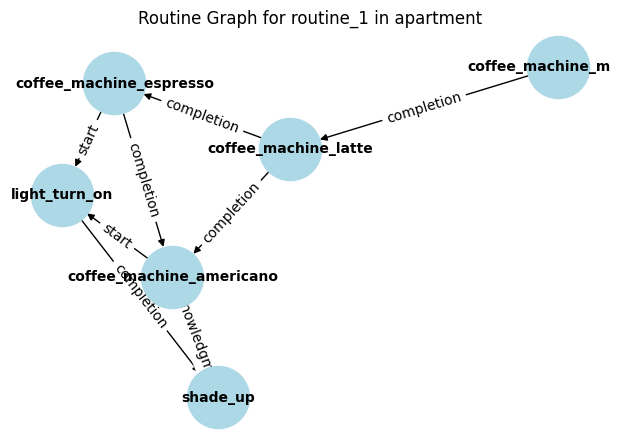

Routine for device: routine_2
['coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_latte', 'light_turn_off', 'light_turn_on', 'dishwasher_dry', 'dishwasher_rinse', 'toaster_toast']


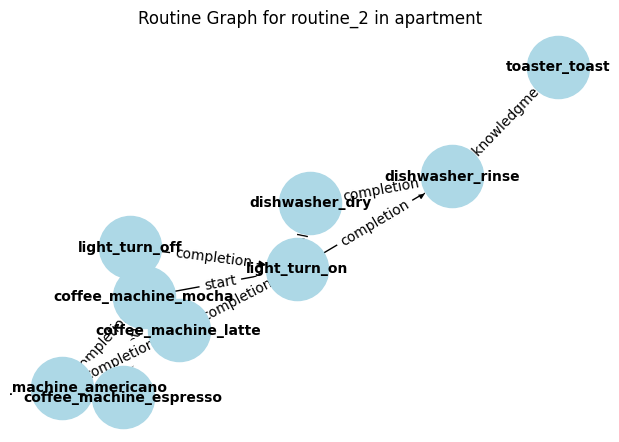

Routine for device: routine_3
['dishwasher_wash', 'dishwasher_rinse', 'dishwasher_dry', 'oven_roast', 'oven_bake', 'oven_broil', 'vacuum_clean', 'coffee_machine_americano', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'dryer_dry', 'thermostat_off', 'thermostat_cool', 'light_turn_on', 'shade_down', 'shade_up', 'door_open', 'door_close']


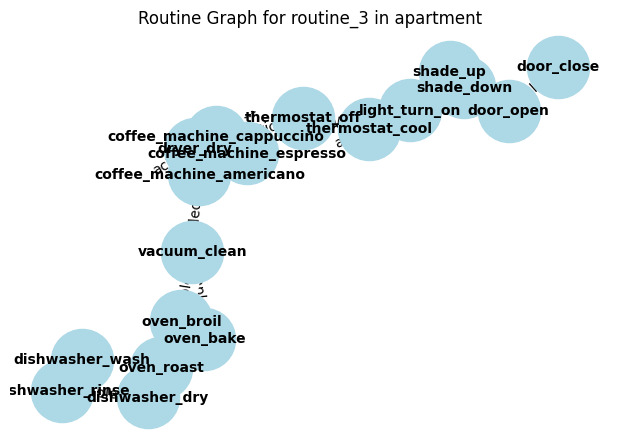

Routine for device: routine_4
['toaster_toast', 'dryer_dry']


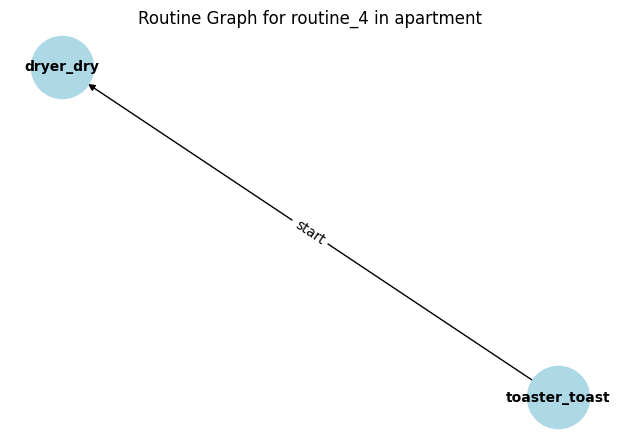

Routine for device: routine_5
['toaster_toast', 'coffee_machine_americano', 'door_close', 'door_open', 'dishwasher_rinse', 'vacuum_return_to_base', 'dryer_dry', 'microwave_heat']


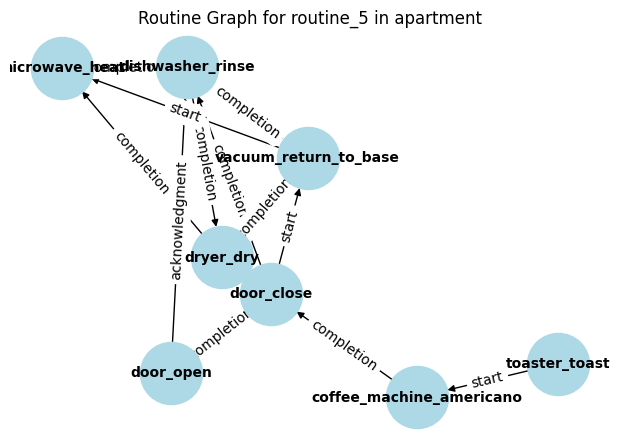

Routine for device: routine_6
['coffee_machine_espresso', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'coffee_machine_americano', 'coffee_machine_mocha', 'dryer_dry']


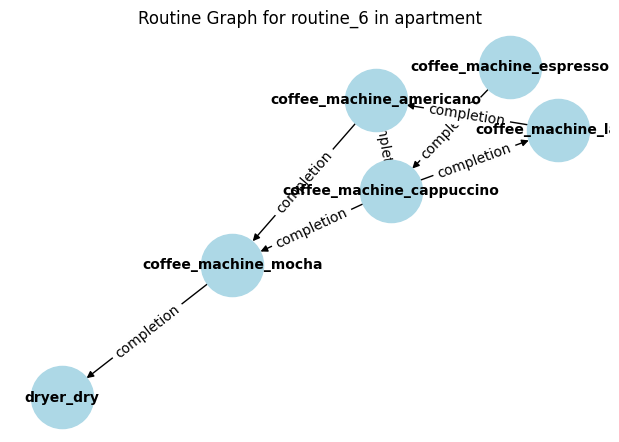

Routine for device: routine_7
['washer_wash', 'washer_spin', 'washer_rinse', 'shade_down', 'shade_up', 'thermostat_heat', 'thermostat_off', 'thermostat_cool', 'coffee_machine_mocha', 'coffee_machine_americano', 'oven_roast', 'oven_bake', 'dryer_dry', 'light_turn_on', 'light_turn_off', 'door_close', 'window_close', 'window_open', 'toaster_toast', 'microwave_heat']


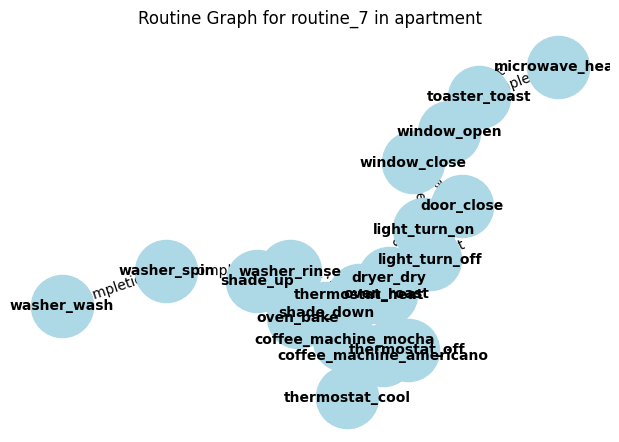

Routine for device: routine_8
['microwave_heat', 'oven_broil', 'oven_bake', 'oven_roast', 'dryer_dry', 'light_turn_on', 'door_close', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'washer_spin', 'washer_rinse', 'vacuum_clean', 'window_close']


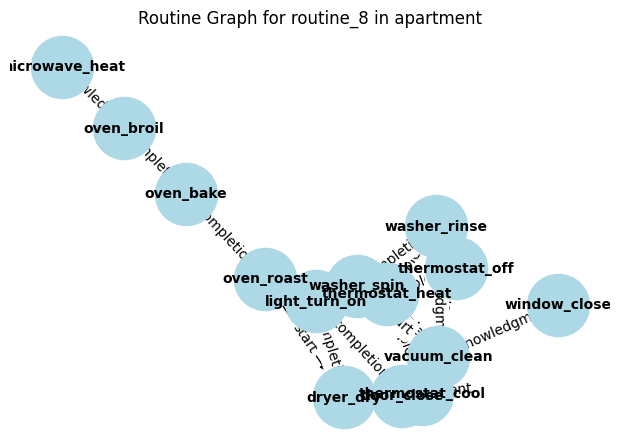

Routine for device: routine_9
['dryer_dry', 'toaster_toast', 'vacuum_return_to_base', 'vacuum_clean', 'thermostat_off', 'thermostat_heat', 'coffee_machine_espresso', 'coffee_machine_mocha', 'coffee_machine_americano', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'door_open', 'light_turn_on', 'light_turn_off', 'washer_spin', 'washer_wash', 'washer_rinse']


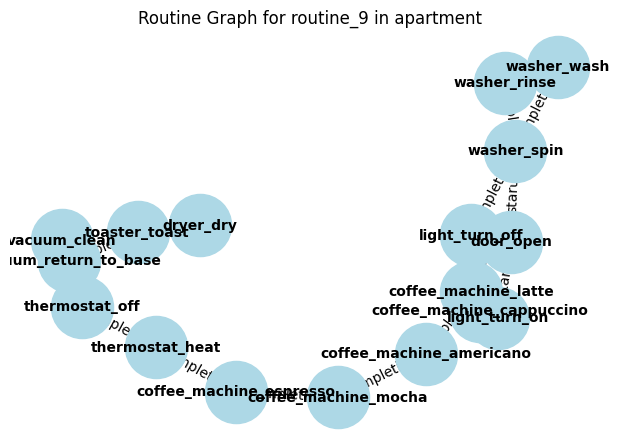

Routine for device: routine_10
['vacuum_clean', 'vacuum_return_to_base']


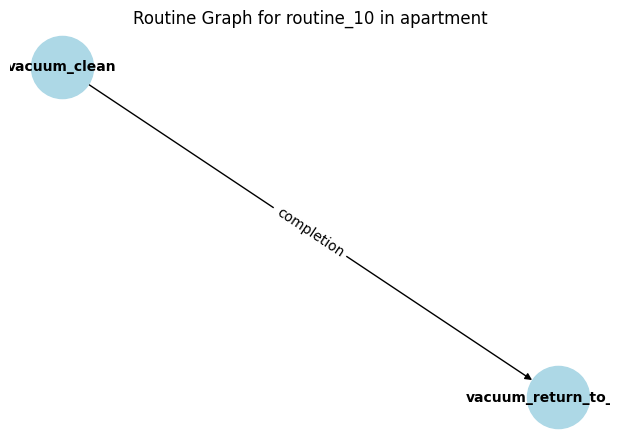

Routine for device: routine_11
['window_open', 'window_close', 'dishwasher_dry', 'dishwasher_wash']


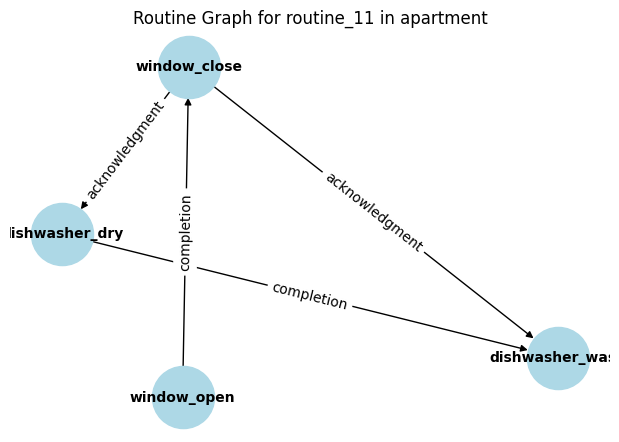

Routine for device: routine_12
['door_close', 'washer_spin']


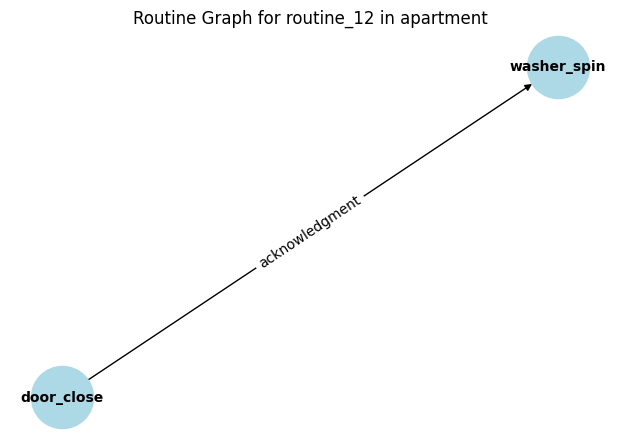

Routine for device: routine_13
['coffee_machine_espresso', 'coffee_machine_latte', 'dryer_dry', 'shade_down', 'shade_up', 'oven_broil', 'thermostat_off', 'thermostat_cool', 'thermostat_heat', 'washer_wash', 'washer_spin', 'light_turn_off', 'dishwasher_wash', 'door_open', 'window_open', 'window_close', 'toaster_toast']


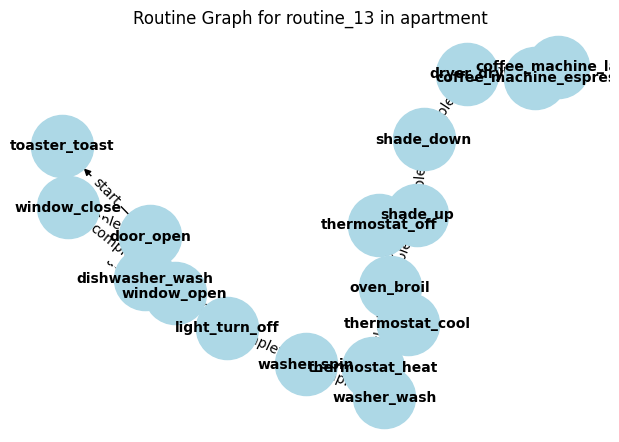

Routine for device: routine_14
['microwave_heat', 'thermostat_heat', 'thermostat_cool', 'thermostat_off', 'toaster_toast', 'vacuum_return_to_base', 'dishwasher_dry', 'dishwasher_rinse']


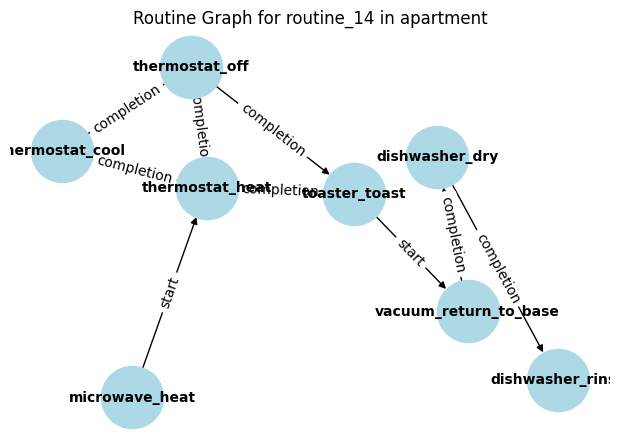

Generated routines for house1fl:
Routine for device: routine_0
['thermostat_heat', 'thermostat_cool', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'coffee_machine_mocha', 'coffee_machine_americano', 'mower_mow', 'mower_return_to_base', 'light_turn_on', 'shade_up', 'dryer_dry', 'washer_wash', 'washer_rinse', 'washer_spin', 'oven_bake', 'sprinkler_water', 'dishwasher_dry', 'dishwasher_wash', 'toaster_toast', 'vacuum_return_to_base', 'vacuum_clean', 'microwave_heat', 'window_open']


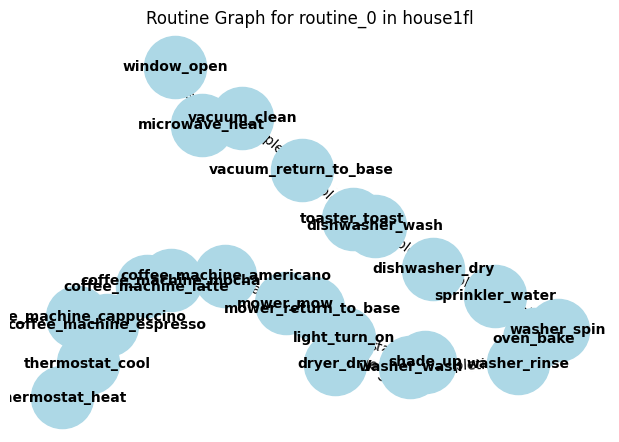

Routine for device: routine_1
['sprinkler_water', 'thermostat_heat', 'thermostat_cool']


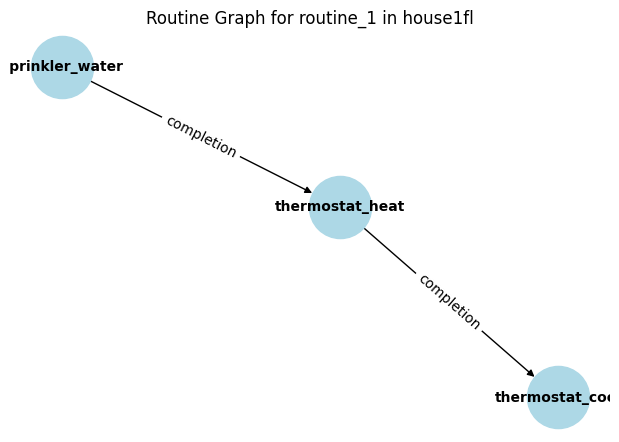

Routine for device: routine_2
['washer_rinse', 'washer_spin', 'dishwasher_dry', 'shade_down', 'vacuum_clean', 'vacuum_return_to_base', 'window_open', 'window_close', 'thermostat_heat', 'door_close', 'door_open', 'light_turn_off', 'microwave_heat', 'sprinkler_water', 'dryer_dry', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'coffee_machine_mocha', 'coffee_machine_espresso', 'toaster_toast', 'mower_return_to_base', 'mower_mow', 'oven_roast', 'oven_bake']


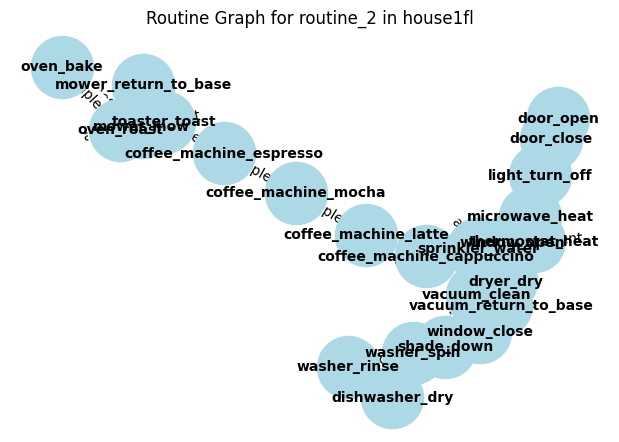

Routine for device: routine_3
['window_open', 'window_close']


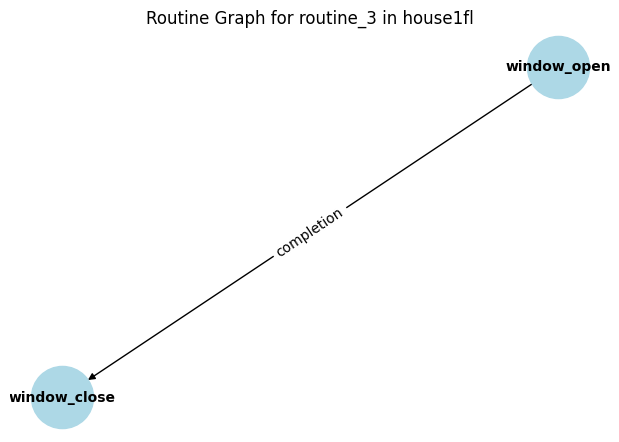

Routine for device: routine_4
['toaster_toast', 'microwave_heat', 'shade_up']


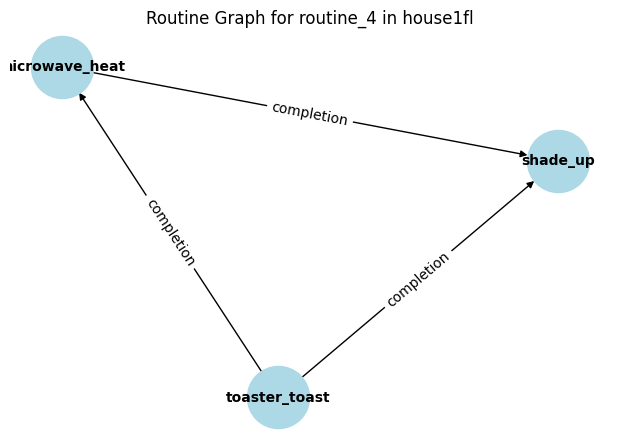

Routine for device: routine_5
['toaster_toast', 'mower_return_to_base', 'sprinkler_water', 'oven_broil', 'oven_bake', 'oven_roast', 'door_open', 'door_close', 'dryer_dry', 'shade_up', 'shade_down']


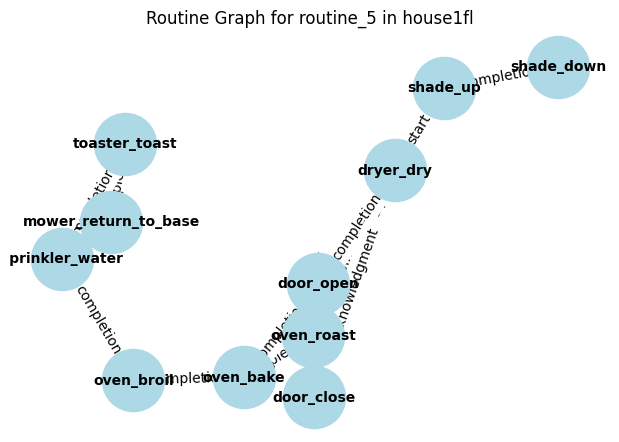

Routine for device: routine_6
['washer_spin', 'toaster_toast', 'shade_down', 'shade_up', 'vacuum_clean', 'dishwasher_dry', 'dishwasher_wash', 'coffee_machine_espresso', 'light_turn_off', 'microwave_heat', 'window_open', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'dryer_dry', 'door_open', 'oven_broil', 'mower_mow', 'mower_return_to_base']


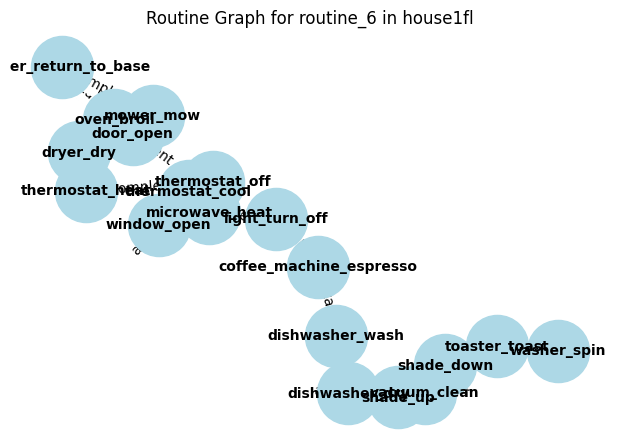

Routine for device: routine_7
['thermostat_cool', 'thermostat_heat', 'dryer_dry', 'coffee_machine_americano', 'coffee_machine_mocha', 'light_turn_on', 'light_turn_off']


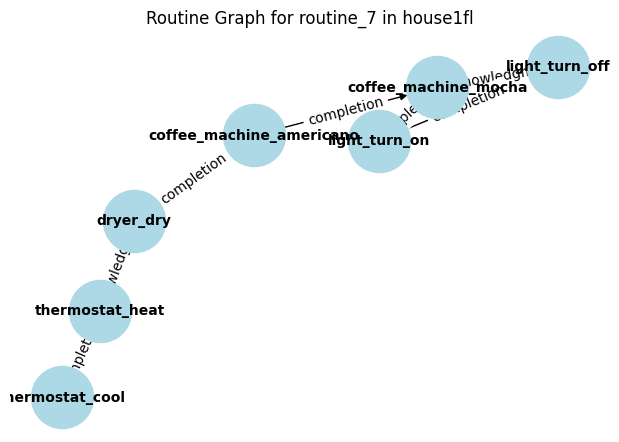

Routine for device: routine_8
['shade_down', 'shade_up']


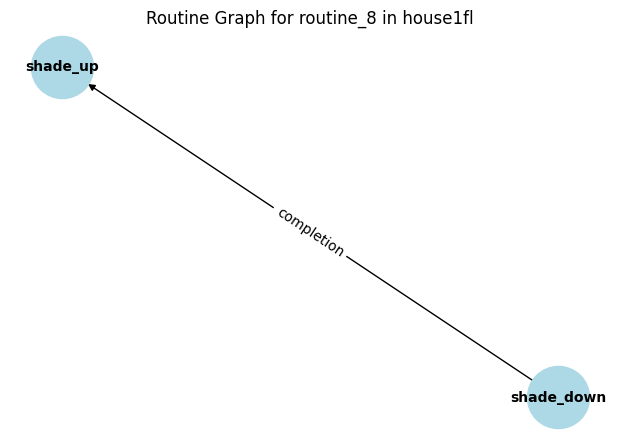

Routine for device: routine_9
['shade_up', 'dryer_dry', 'dishwasher_dry', 'thermostat_cool', 'thermostat_heat']


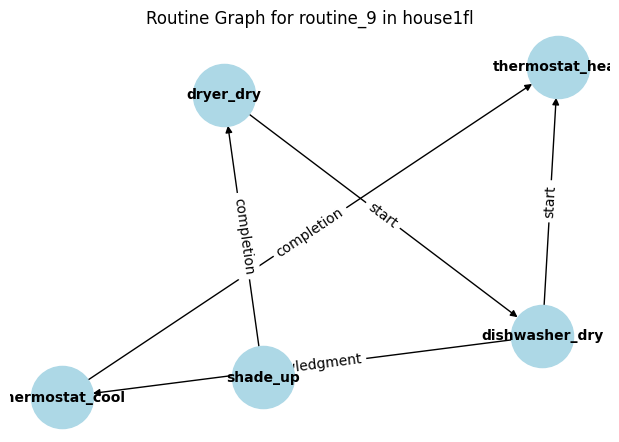

Routine for device: routine_10
['light_turn_off', 'thermostat_cool', 'microwave_heat', 'mower_return_to_base', 'door_close', 'vacuum_clean', 'vacuum_return_to_base', 'sprinkler_water', 'shade_down', 'washer_wash', 'toaster_toast', 'window_open', 'window_close', 'dryer_dry', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'oven_roast', 'oven_broil']


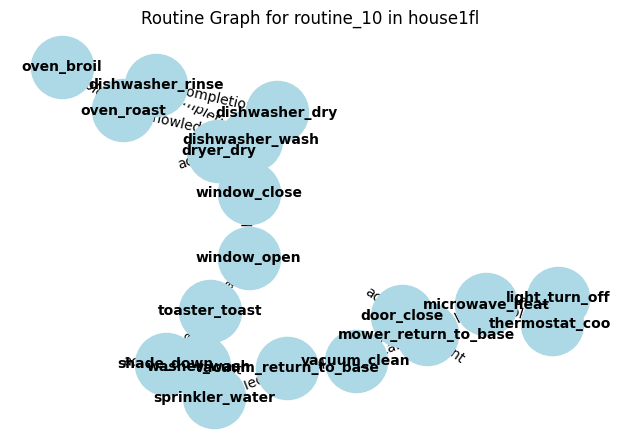

Routine for device: routine_11
['microwave_heat', 'oven_roast', 'oven_bake', 'oven_broil', 'toaster_toast']


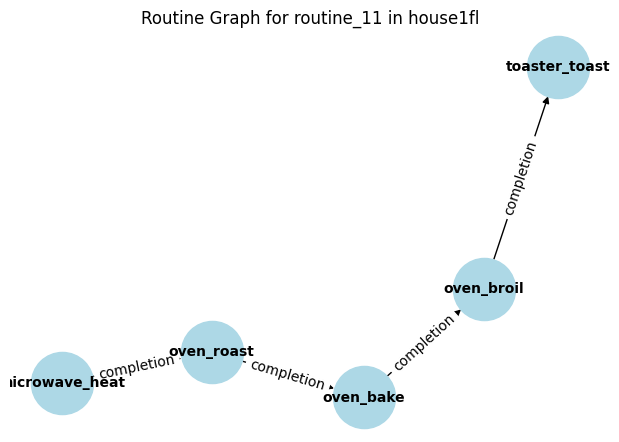

Routine for device: routine_12
['toaster_toast', 'washer_spin', 'sprinkler_water', 'thermostat_off', 'thermostat_heat', 'mower_return_to_base', 'oven_bake', 'oven_roast', 'oven_broil', 'microwave_heat', 'window_close', 'window_open', 'dryer_dry', 'dishwasher_dry', 'dishwasher_rinse', 'dishwasher_wash', 'light_turn_on', 'light_turn_off', 'door_close', 'door_open', 'shade_up', 'shade_down', 'coffee_machine_cappuccino', 'coffee_machine_americano']


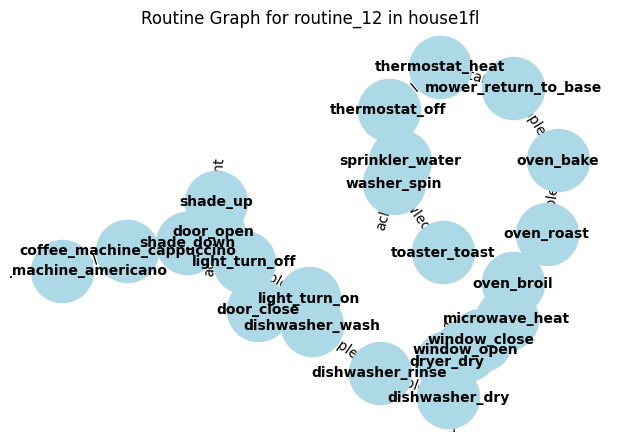

Routine for device: routine_13
['vacuum_clean', 'washer_wash', 'washer_spin', 'washer_rinse', 'shade_down', 'microwave_heat']


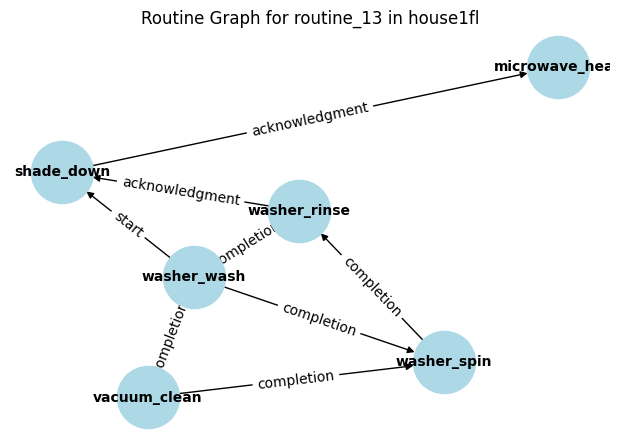

Routine for device: routine_14
['thermostat_off', 'window_close', 'mower_return_to_base', 'vacuum_return_to_base', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_mocha', 'coffee_machine_americano', 'sprinkler_water', 'microwave_heat', 'dryer_dry', 'dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse', 'shade_up', 'light_turn_on', 'light_turn_off', 'door_open', 'toaster_toast', 'washer_rinse', 'washer_wash', 'washer_spin', 'oven_bake']


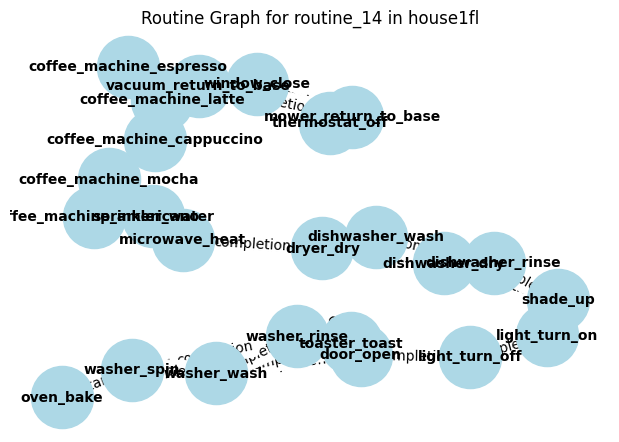

Routine for device: routine_15
['shade_down', 'shade_up', 'window_open', 'window_close', 'sprinkler_water', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_mocha', 'toaster_toast']


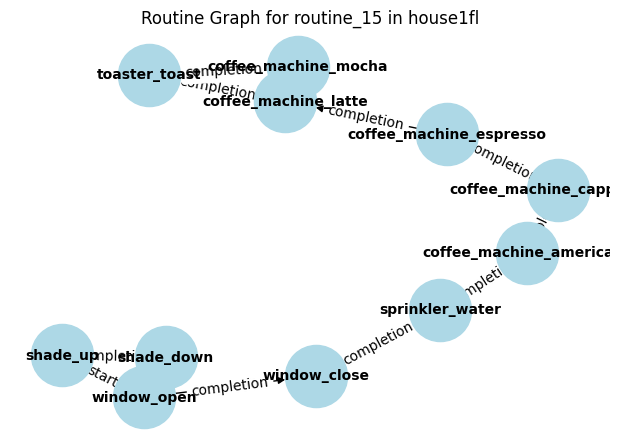

Routine for device: routine_16
['microwave_heat', 'toaster_toast', 'thermostat_cool', 'thermostat_heat', 'thermostat_off', 'mower_return_to_base', 'shade_down', 'shade_up', 'dishwasher_dry', 'dishwasher_rinse', 'sprinkler_water', 'vacuum_clean']


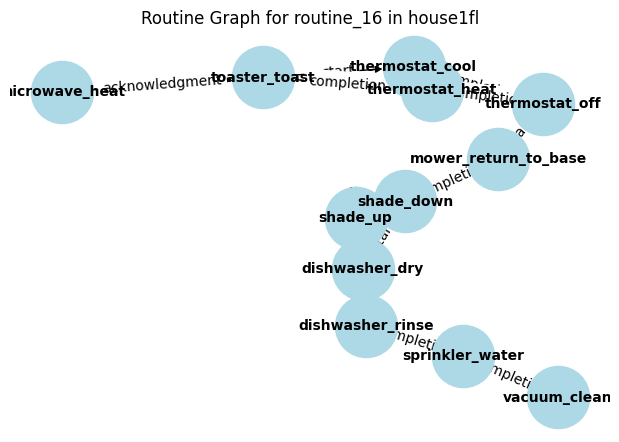

Routine for device: routine_17
['dishwasher_wash', 'dishwasher_rinse', 'vacuum_return_to_base', 'toaster_toast', 'mower_mow', 'mower_return_to_base', 'thermostat_heat', 'thermostat_off', 'sprinkler_water', 'dryer_dry']


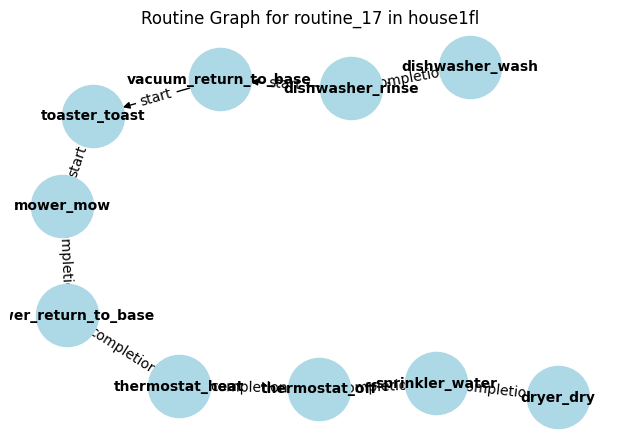

Routine for device: routine_18
['door_close', 'coffee_machine_espresso', 'coffee_machine_americano', 'mower_mow']


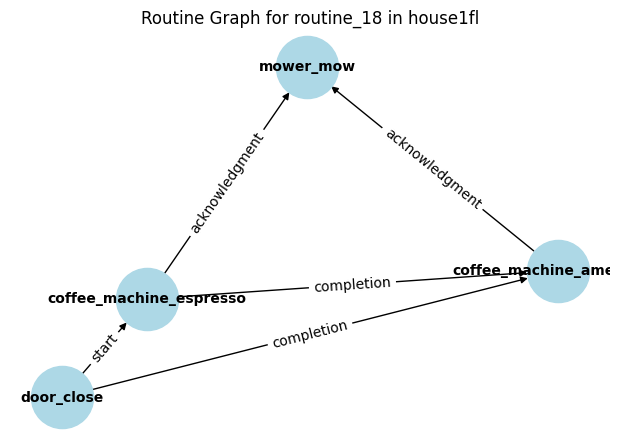

Routine for device: routine_19
['mower_return_to_base', 'mower_mow', 'toaster_toast', 'shade_down', 'shade_up', 'window_close', 'window_open', 'sprinkler_water', 'dryer_dry', 'vacuum_return_to_base', 'light_turn_off', 'light_turn_on', 'microwave_heat', 'dishwasher_dry', 'coffee_machine_mocha', 'coffee_machine_cappuccino', 'oven_roast', 'oven_bake']


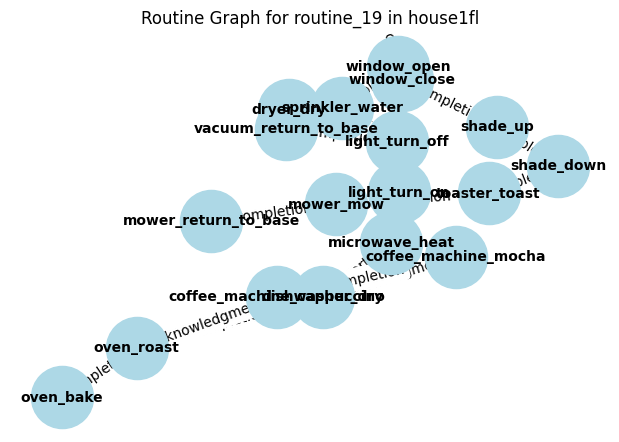

Routine for device: routine_20
['washer_rinse', 'washer_wash', 'shade_up', 'shade_down', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'coffee_machine_espresso', 'window_close', 'dishwasher_wash', 'dishwasher_rinse', 'oven_bake', 'oven_roast', 'oven_broil', 'sprinkler_water', 'mower_mow', 'mower_return_to_base', 'thermostat_heat', 'thermostat_cool', 'thermostat_off', 'dryer_dry', 'vacuum_clean']


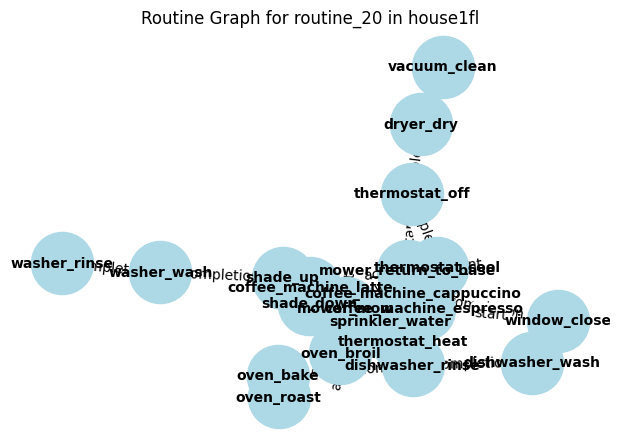

Routine for device: routine_21
['washer_wash', 'washer_rinse', 'toaster_toast', 'vacuum_return_to_base', 'vacuum_clean', 'thermostat_cool', 'sprinkler_water', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_latte', 'door_close', 'microwave_heat', 'shade_up', 'shade_down', 'window_close', 'dryer_dry', 'oven_roast']


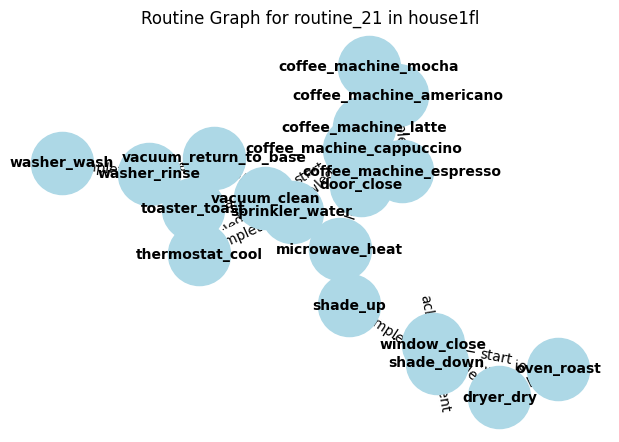

Routine for device: routine_22
['sprinkler_water', 'mower_mow', 'mower_return_to_base', 'oven_bake', 'oven_roast', 'oven_broil', 'microwave_heat', 'vacuum_clean', 'vacuum_return_to_base']


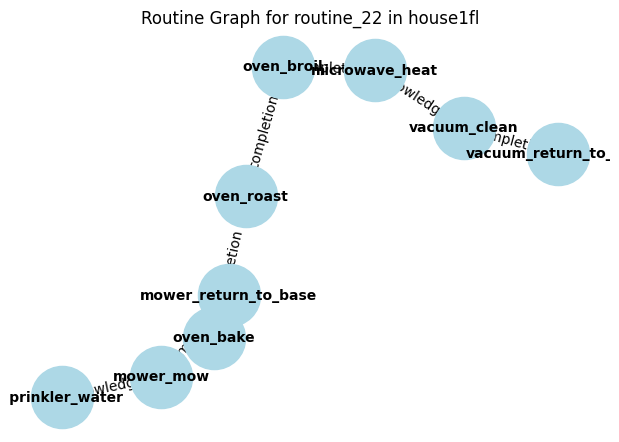

Routine for device: routine_23
['vacuum_clean', 'washer_wash', 'light_turn_off']


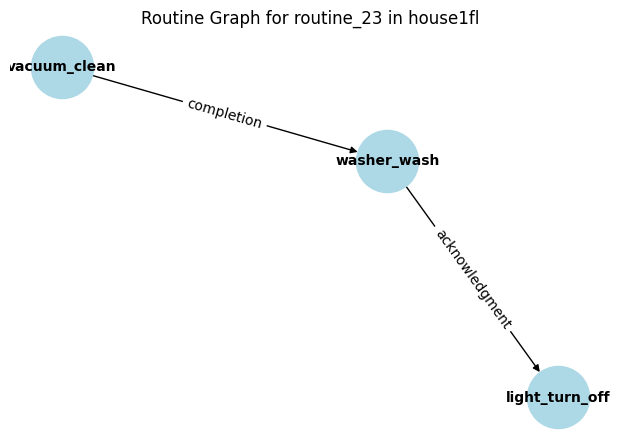

Routine for device: routine_24
['window_close', 'sprinkler_water', 'mower_return_to_base', 'dishwasher_dry']


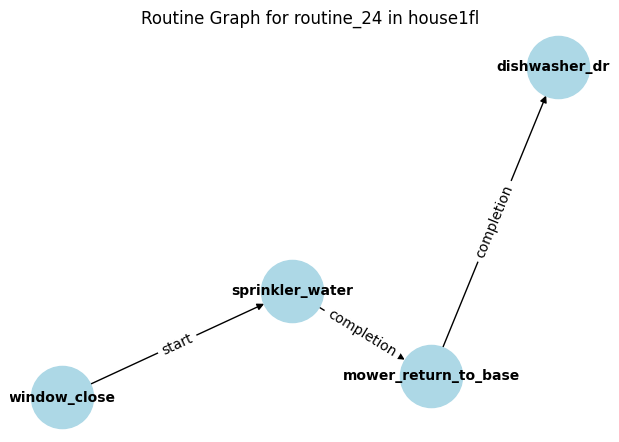

Routine for device: routine_25
['door_close', 'door_open', 'window_open', 'vacuum_return_to_base', 'dishwasher_rinse', 'washer_spin', 'washer_wash', 'light_turn_on', 'light_turn_off', 'thermostat_heat', 'thermostat_cool', 'oven_broil', 'oven_roast', 'oven_bake', 'dryer_dry', 'shade_down', 'shade_up', 'sprinkler_water', 'mower_return_to_base', 'mower_mow', 'microwave_heat', 'coffee_machine_mocha', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'coffee_machine_americano', 'toaster_toast']


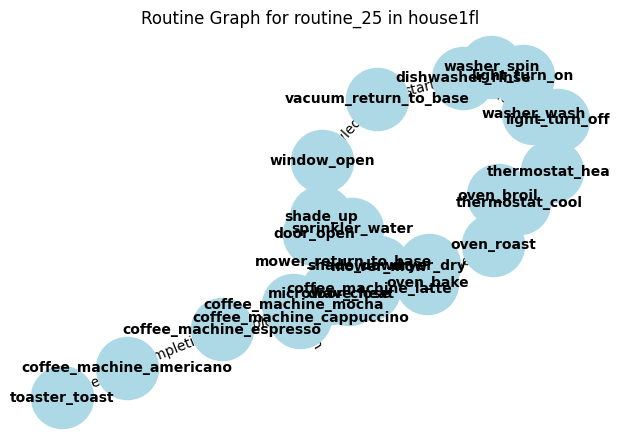

Routine for device: routine_26
['window_open', 'window_close']


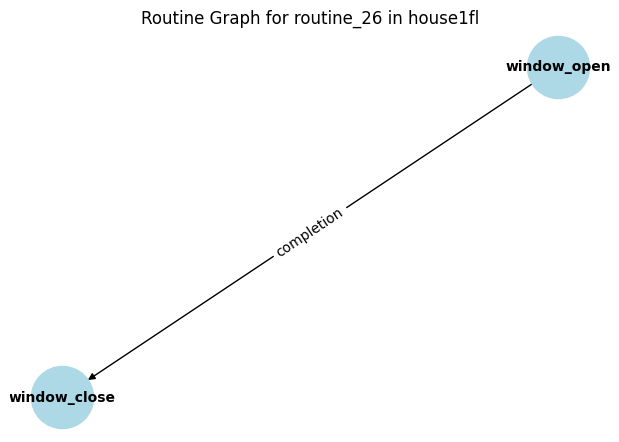

Routine for device: routine_27
['thermostat_cool', 'thermostat_heat', 'shade_down', 'microwave_heat', 'coffee_machine_espresso', 'coffee_machine_americano', 'toaster_toast', 'washer_spin', 'washer_wash', 'washer_rinse', 'oven_broil', 'sprinkler_water', 'dryer_dry', 'vacuum_clean', 'vacuum_return_to_base', 'window_close']


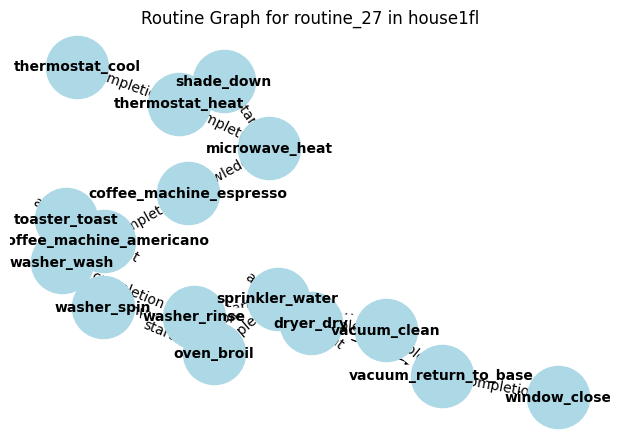

Routine for device: routine_28
['vacuum_clean', 'vacuum_return_to_base', 'window_open', 'mower_return_to_base']


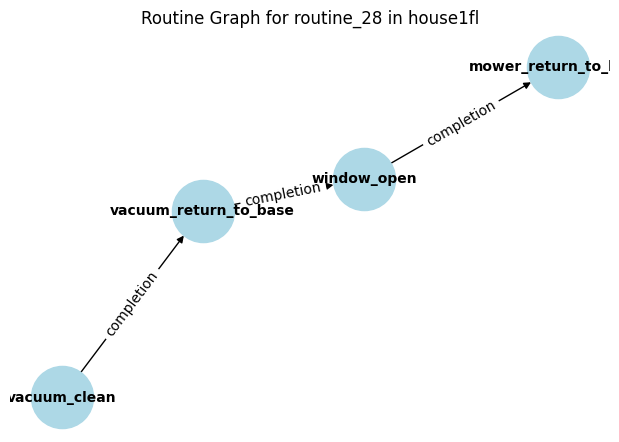

Routine for device: routine_29
['microwave_heat', 'dishwasher_rinse', 'window_close', 'mower_return_to_base', 'sprinkler_water', 'oven_roast', 'thermostat_heat', 'washer_wash', 'washer_spin', 'washer_rinse', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'coffee_machine_mocha', 'shade_down', 'shade_up', 'vacuum_return_to_base', 'dryer_dry']


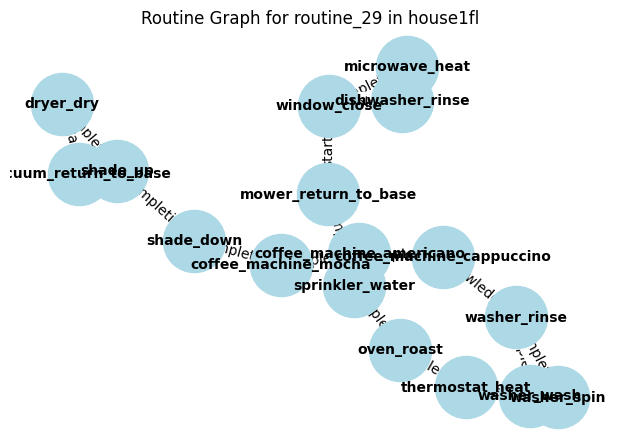

Routine for device: routine_30
['sprinkler_water', 'oven_bake', 'oven_roast', 'toaster_toast']


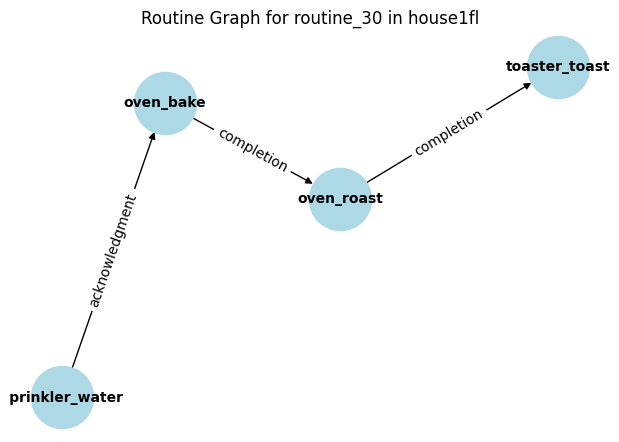

Routine for device: routine_31
['toaster_toast', 'vacuum_clean', 'vacuum_return_to_base', 'microwave_heat']


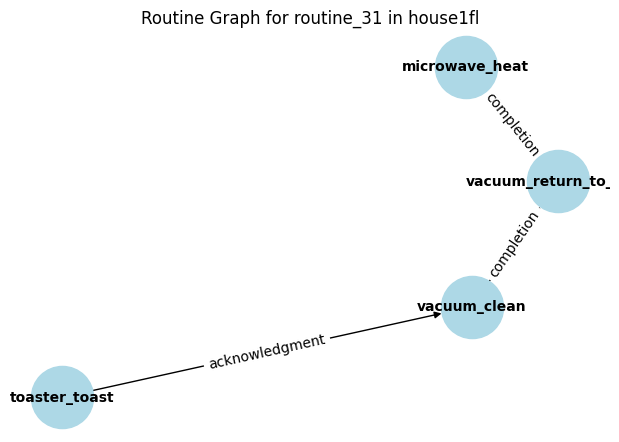

Routine for device: routine_32
['toaster_toast', 'sprinkler_water', 'window_close', 'vacuum_return_to_base', 'vacuum_clean', 'oven_broil', 'oven_roast', 'oven_bake', 'washer_wash', 'dishwasher_rinse', 'shade_down', 'shade_up']


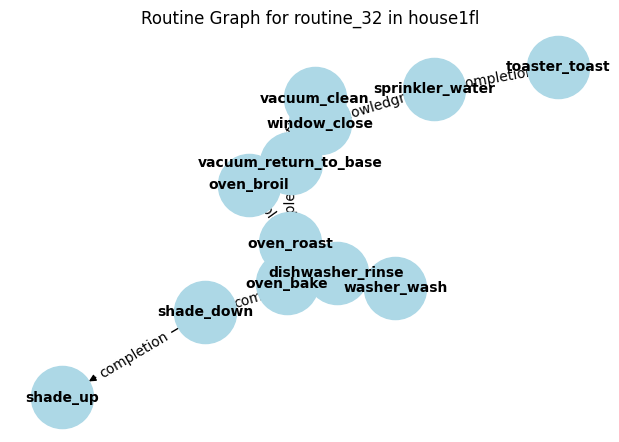

Routine for device: routine_33
['oven_roast', 'toaster_toast', 'light_turn_on', 'light_turn_off', 'window_open', 'mower_return_to_base', 'shade_up', 'dryer_dry', 'door_open', 'door_close', 'vacuum_clean', 'washer_wash', 'washer_rinse', 'washer_spin', 'coffee_machine_cappuccino', 'thermostat_cool', 'dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse', 'sprinkler_water', 'microwave_heat']


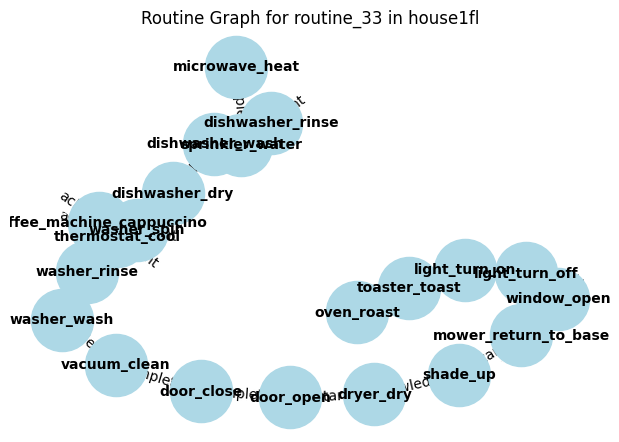

Routine for device: routine_34
['washer_wash', 'washer_rinse', 'washer_spin', 'door_close', 'door_open', 'shade_down', 'shade_up', 'window_open', 'toaster_toast', 'vacuum_clean', 'vacuum_return_to_base', 'oven_roast', 'oven_bake', 'light_turn_on', 'microwave_heat', 'mower_return_to_base', 'mower_mow', 'dryer_dry', 'sprinkler_water', 'dishwasher_wash', 'dishwasher_rinse', 'thermostat_off', 'thermostat_cool', 'thermostat_heat', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_latte']


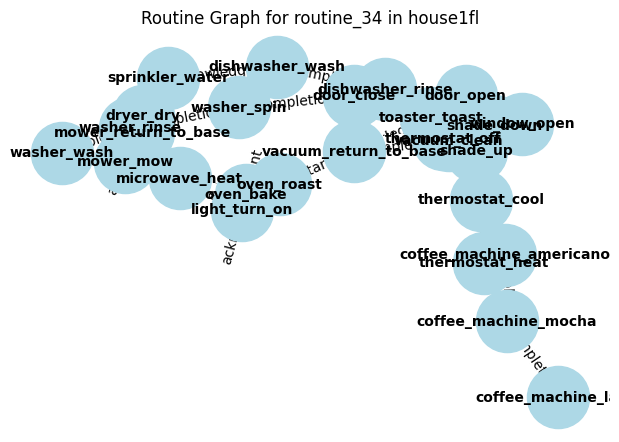

Routine for device: routine_35
['window_open', 'window_close', 'toaster_toast', 'thermostat_cool', 'thermostat_heat', 'thermostat_off']


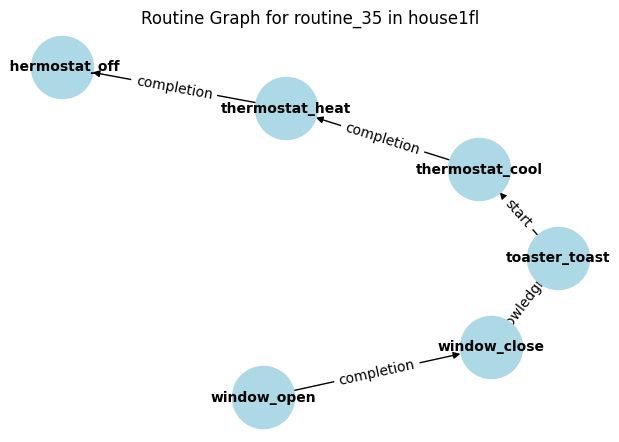

Routine for device: routine_36
['shade_down', 'oven_bake', 'oven_roast', 'oven_broil', 'microwave_heat', 'window_close', 'vacuum_clean', 'vacuum_return_to_base', 'toaster_toast', 'dishwasher_wash', 'dishwasher_rinse', 'dishwasher_dry', 'sprinkler_water', 'mower_mow', 'dryer_dry', 'coffee_machine_cappuccino', 'door_open', 'door_close', 'light_turn_on', 'thermostat_off']


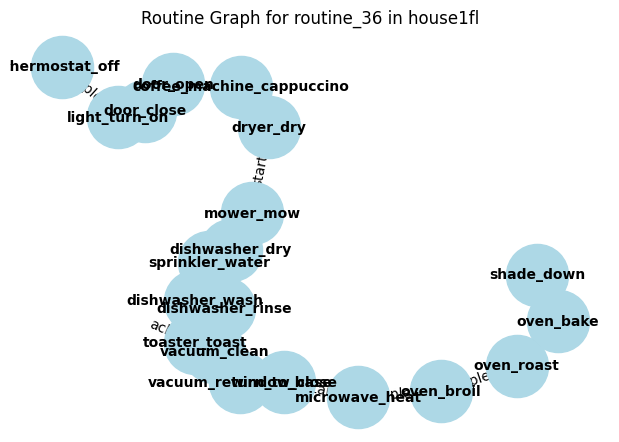

Routine for device: routine_37
['sprinkler_water', 'thermostat_off', 'thermostat_cool', 'microwave_heat', 'dryer_dry', 'shade_up', 'shade_down', 'door_close', 'door_open', 'light_turn_on', 'coffee_machine_mocha', 'coffee_machine_americano', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'mower_mow', 'toaster_toast', 'washer_wash']


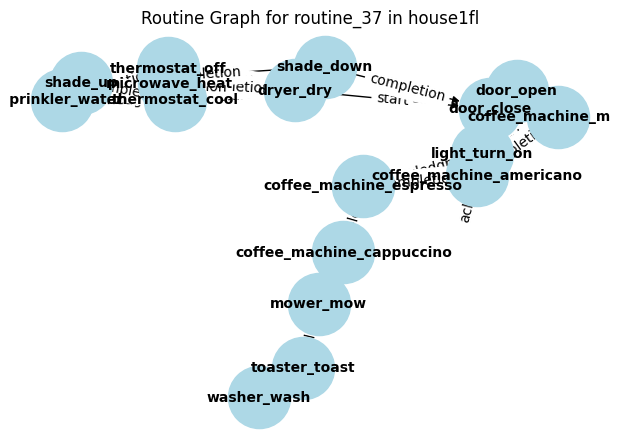

Routine for device: routine_38
['light_turn_off', 'light_turn_on', 'window_close', 'window_open', 'vacuum_clean', 'vacuum_return_to_base', 'microwave_heat', 'sprinkler_water', 'toaster_toast', 'dishwasher_rinse', 'oven_broil', 'oven_roast', 'oven_bake', 'shade_up', 'shade_down', 'coffee_machine_latte', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'door_close', 'washer_rinse', 'washer_wash']


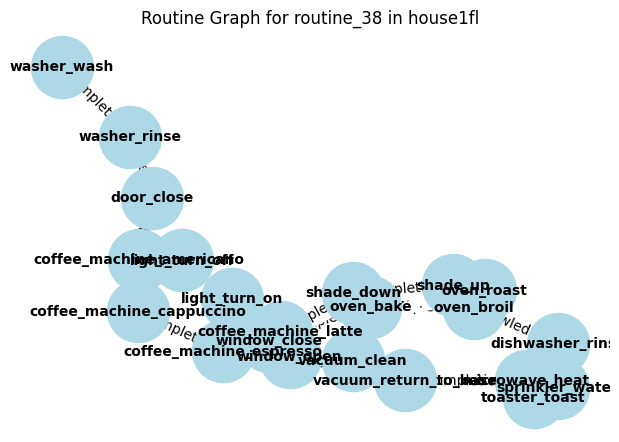

Routine for device: routine_39
['sprinkler_water', 'door_open', 'coffee_machine_mocha', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_americano']


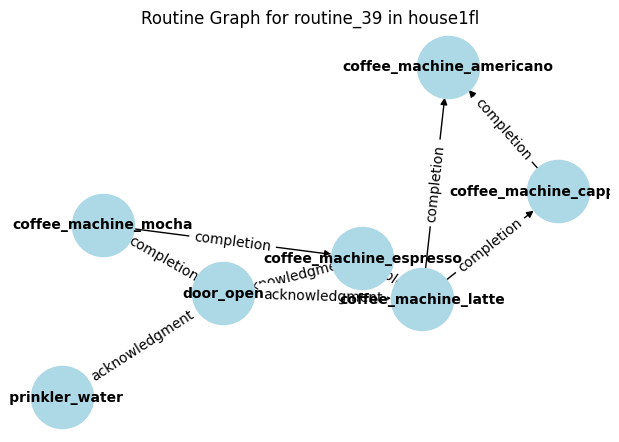

Routine for device: routine_40
['door_open', 'washer_rinse', 'sprinkler_water', 'vacuum_return_to_base', 'vacuum_clean', 'window_open', 'window_close']


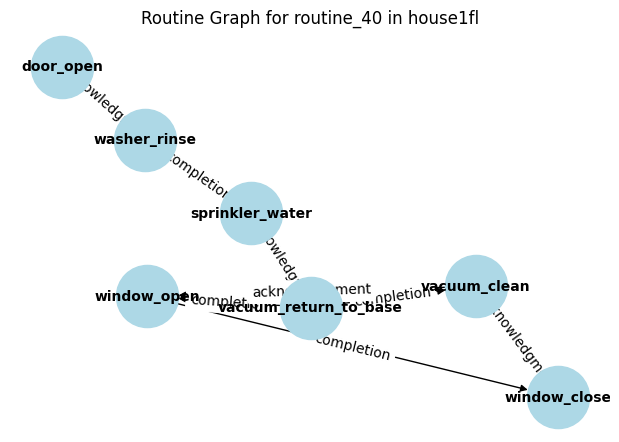

Routine for device: routine_41
['window_close', 'window_open']


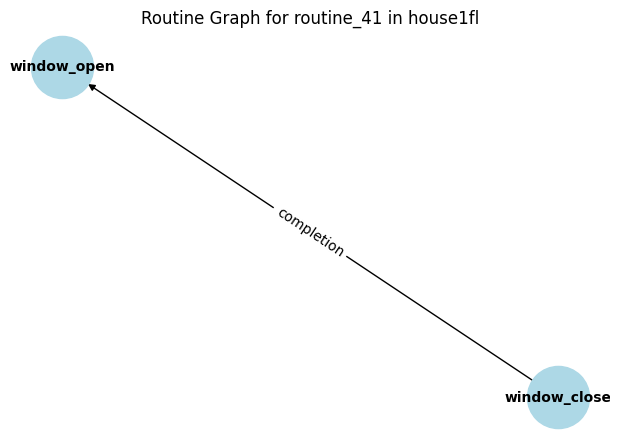

Routine for device: routine_42
['sprinkler_water', 'shade_up', 'shade_down', 'door_close', 'door_open', 'washer_rinse', 'dishwasher_wash', 'dishwasher_dry', 'coffee_machine_latte', 'coffee_machine_espresso', 'toaster_toast', 'thermostat_heat', 'thermostat_off', 'thermostat_cool', 'microwave_heat', 'oven_roast', 'oven_bake', 'window_close', 'window_open']


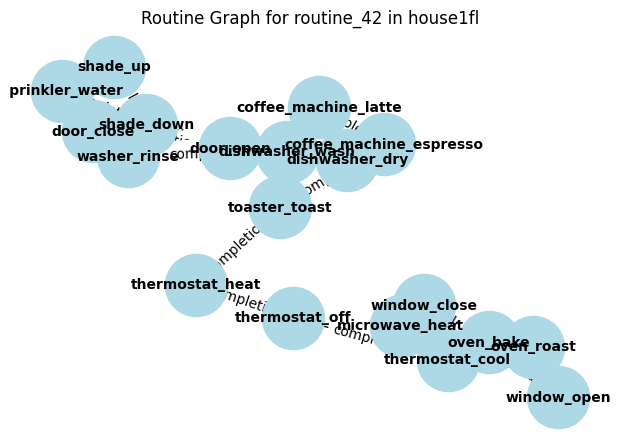

Routine for device: routine_43
['sprinkler_water', 'dishwasher_rinse', 'dishwasher_wash', 'dishwasher_dry', 'toaster_toast', 'door_close', 'mower_mow', 'mower_return_to_base', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'coffee_machine_mocha', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'oven_roast', 'dryer_dry', 'vacuum_clean', 'window_close', 'washer_rinse', 'washer_spin', 'microwave_heat', 'shade_up', 'shade_down']


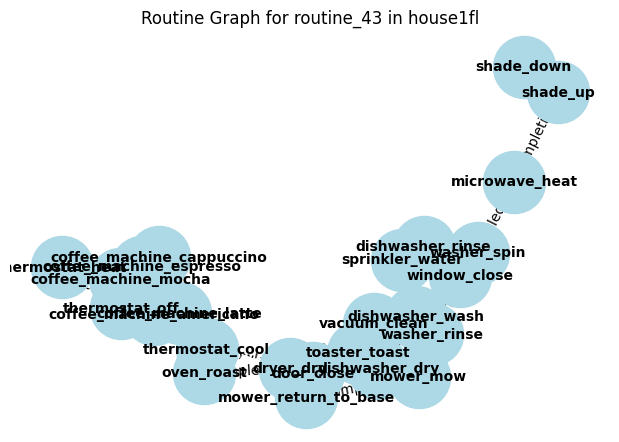

Routine for device: routine_44
['coffee_machine_latte', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_cappuccino', 'oven_roast', 'oven_bake', 'oven_broil', 'light_turn_on', 'light_turn_off', 'thermostat_cool', 'window_open', 'toaster_toast', 'microwave_heat', 'mower_mow', 'shade_down', 'door_close', 'door_open', 'sprinkler_water', 'washer_wash', 'washer_spin', 'washer_rinse', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'vacuum_clean', 'dryer_dry']


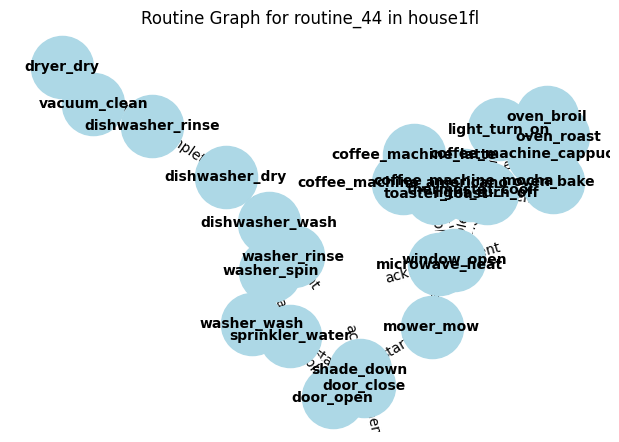

Routine for device: routine_45
['dishwasher_wash', 'dishwasher_rinse', 'dishwasher_dry', 'mower_return_to_base', 'mower_mow', 'washer_rinse', 'vacuum_return_to_base', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_cappuccino', 'sprinkler_water']


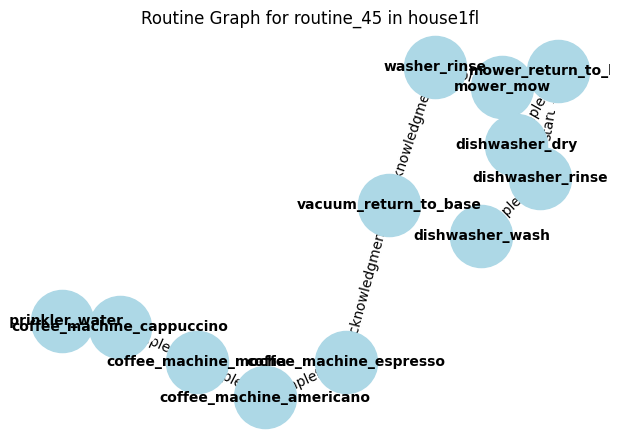

Routine for device: routine_46
['vacuum_clean', 'vacuum_return_to_base', 'window_open']


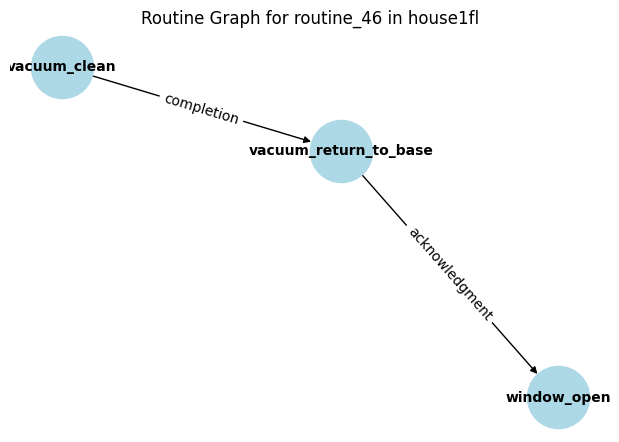

Routine for device: routine_47
['vacuum_return_to_base', 'vacuum_clean', 'dishwasher_rinse', 'dishwasher_dry', 'dishwasher_wash', 'mower_return_to_base', 'mower_mow', 'light_turn_off', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'washer_wash', 'washer_rinse', 'sprinkler_water', 'dryer_dry', 'window_open', 'window_close', 'toaster_toast', 'shade_up', 'shade_down']


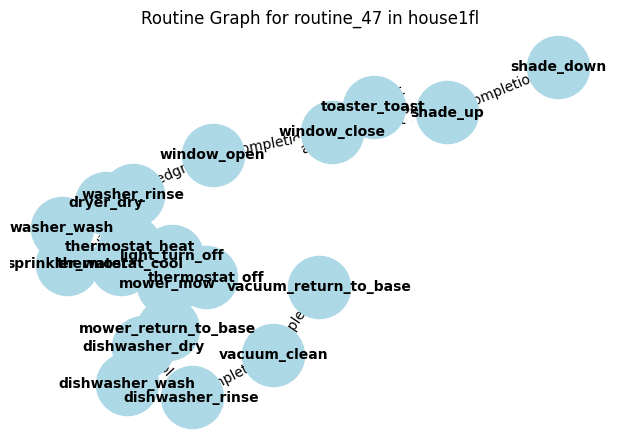

Routine for device: routine_48
['toaster_toast', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'coffee_machine_latte', 'dryer_dry', 'mower_return_to_base', 'mower_mow', 'vacuum_clean', 'washer_spin', 'shade_down', 'thermostat_heat', 'microwave_heat', 'door_close', 'door_open', 'window_close', 'dishwasher_dry']


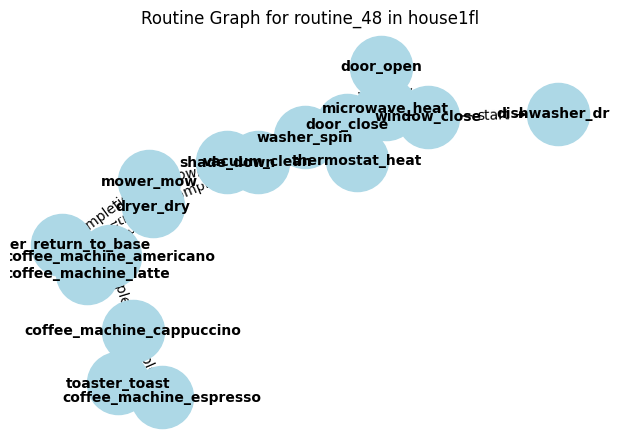

Routine for device: routine_49
['shade_down', 'window_open', 'sprinkler_water', 'thermostat_off', 'coffee_machine_americano', 'coffee_machine_latte']


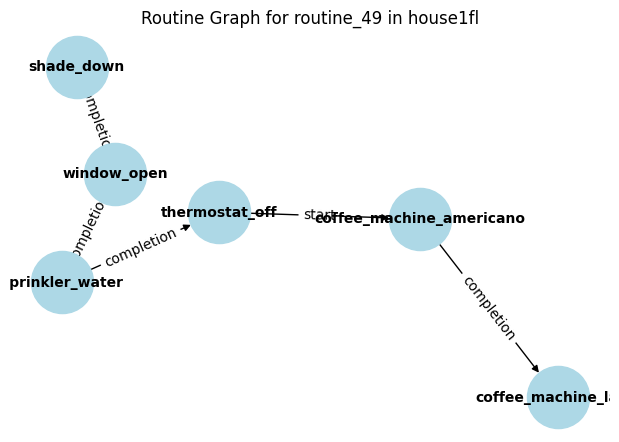

Generated routines for house2fl:
Routine for device: routine_0
['washer_wash', 'mower_return_to_base', 'mower_mow', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'door_close', 'vacuum_clean', 'microwave_heat', 'light_turn_on', 'light_turn_off', 'oven_roast', 'toaster_toast', 'sprinkler_water', 'dishwasher_wash', 'dishwasher_rinse', 'dryer_dry', 'thermostat_heat', 'thermostat_off', 'window_close']


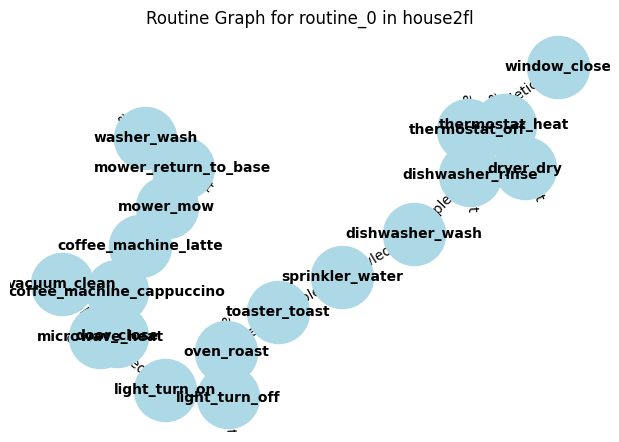

Routine for device: routine_1
['sprinkler_water', 'vacuum_clean', 'dryer_dry', 'washer_spin', 'thermostat_off', 'thermostat_heat', 'dishwasher_dry', 'light_turn_off', 'light_turn_on', 'shade_up', 'mower_return_to_base', 'oven_bake', 'oven_roast', 'oven_broil', 'microwave_heat', 'window_open']


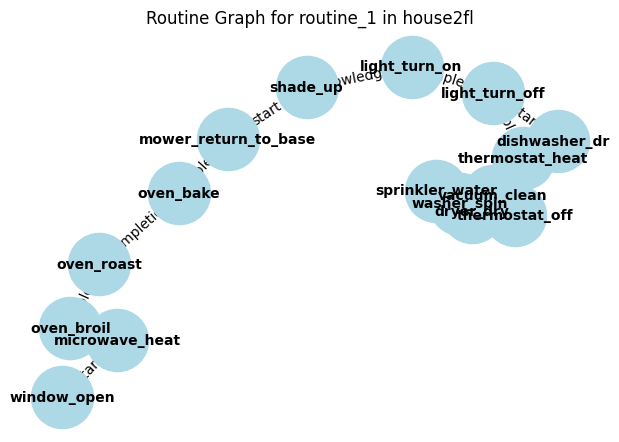

Routine for device: routine_2
['thermostat_heat', 'thermostat_off', 'dishwasher_rinse', 'dishwasher_wash', 'dishwasher_dry', 'oven_broil', 'oven_roast', 'mower_return_to_base', 'mower_mow', 'shade_up', 'shade_down', 'dryer_dry', 'window_close', 'window_open', 'toaster_toast', 'sprinkler_water']


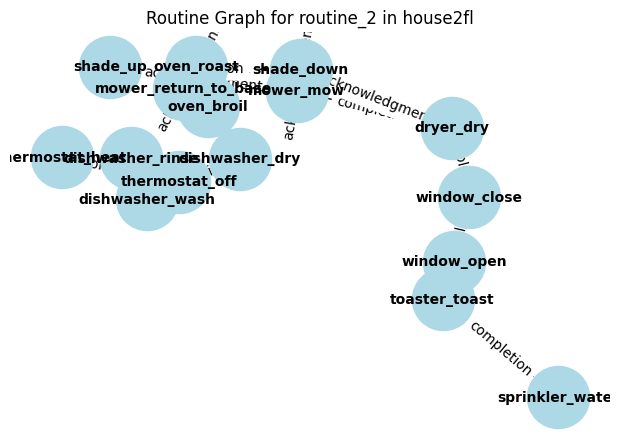

Routine for device: routine_3
['door_close', 'door_open', 'oven_broil', 'thermostat_off', 'thermostat_heat', 'thermostat_cool', 'toaster_toast']


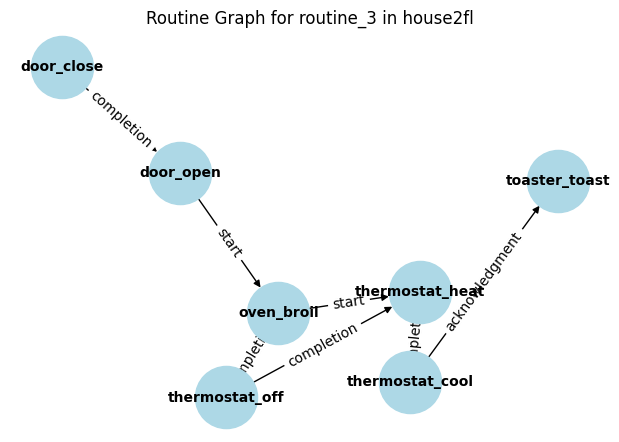

Routine for device: routine_4
['toaster_toast', 'door_open', 'door_close', 'vacuum_clean', 'vacuum_return_to_base', 'microwave_heat', 'washer_wash', 'sprinkler_water', 'light_turn_off', 'light_turn_on', 'dryer_dry', 'oven_broil', 'oven_bake', 'shade_up', 'shade_down', 'coffee_machine_espresso', 'dishwasher_wash', 'dishwasher_rinse']


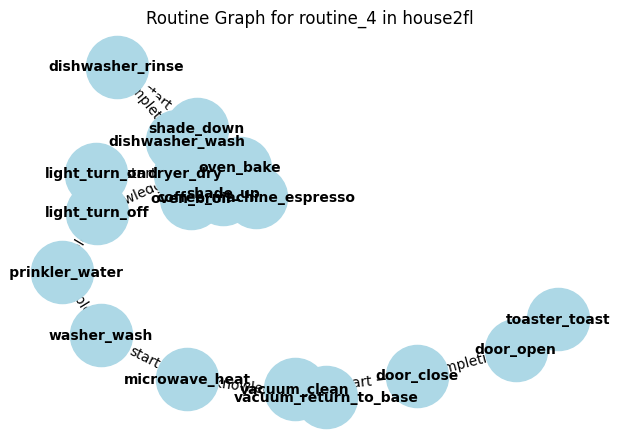

Routine for device: routine_5
['oven_roast', 'oven_broil', 'dishwasher_wash', 'toaster_toast']


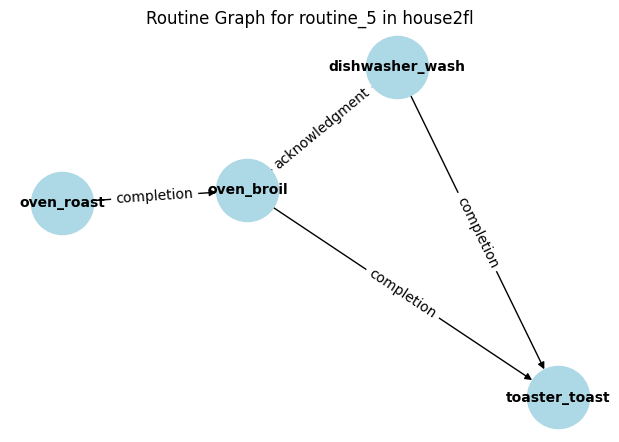

Routine for device: routine_6
['vacuum_return_to_base', 'sprinkler_water', 'thermostat_heat', 'thermostat_off', 'thermostat_cool', 'toaster_toast', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'oven_broil', 'oven_bake', 'window_close', 'shade_down', 'shade_up', 'washer_rinse', 'washer_wash', 'mower_mow', 'light_turn_off', 'light_turn_on', 'door_close', 'door_open', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'microwave_heat']


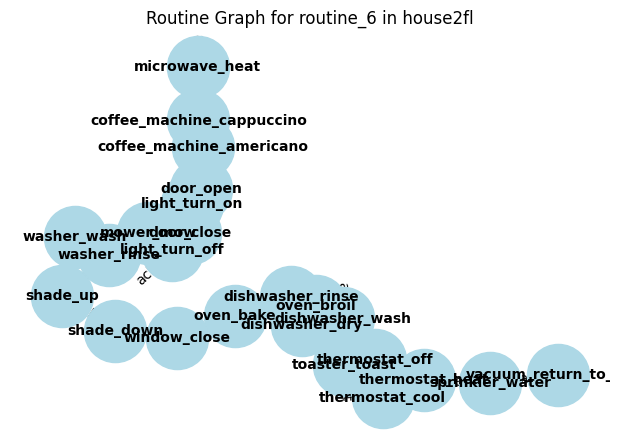

Routine for device: routine_7
['washer_rinse', 'washer_spin', 'washer_wash', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_mocha', 'microwave_heat', 'shade_down', 'toaster_toast', 'thermostat_heat', 'thermostat_off', 'thermostat_cool', 'vacuum_return_to_base', 'mower_mow', 'mower_return_to_base', 'sprinkler_water', 'light_turn_off', 'light_turn_on', 'dishwasher_wash', 'dishwasher_dry', 'dryer_dry', 'oven_bake', 'window_open', 'window_close']


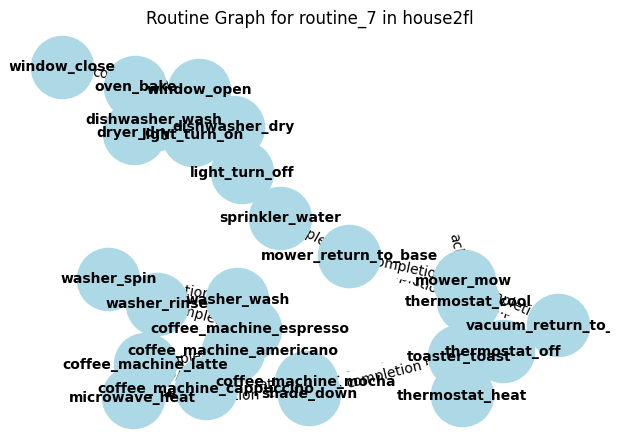

Routine for device: routine_8
['mower_mow', 'mower_return_to_base', 'sprinkler_water', 'dishwasher_wash', 'dishwasher_rinse', 'vacuum_return_to_base', 'washer_spin', 'washer_wash', 'washer_rinse']


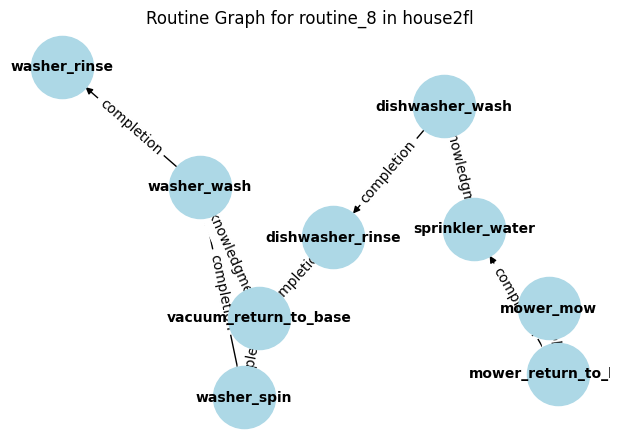

Routine for device: routine_9
['microwave_heat', 'thermostat_cool', 'dryer_dry', 'door_close', 'dishwasher_wash', 'window_open', 'window_close', 'light_turn_off', 'light_turn_on', 'vacuum_clean', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'shade_down', 'mower_mow', 'mower_return_to_base', 'toaster_toast', 'sprinkler_water']


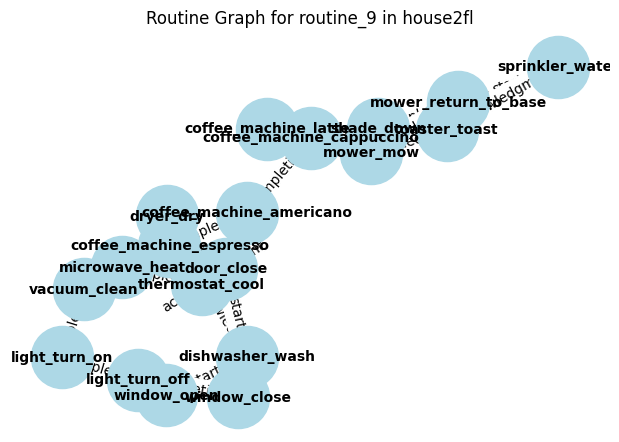

Routine for device: routine_10
['mower_mow', 'thermostat_off', 'thermostat_cool', 'thermostat_heat', 'vacuum_clean', 'door_close', 'door_open', 'window_open', 'dryer_dry', 'toaster_toast', 'dishwasher_dry', 'microwave_heat']


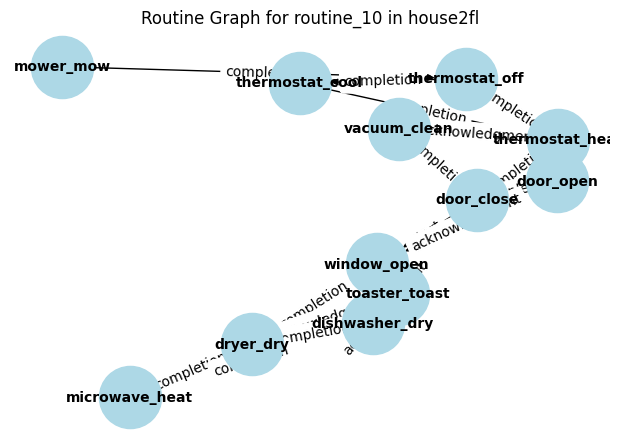

Routine for device: routine_11
['toaster_toast', 'window_open', 'window_close', 'oven_bake', 'oven_broil', 'oven_roast', 'shade_down', 'light_turn_on', 'light_turn_off', 'door_open', 'door_close', 'dryer_dry', 'thermostat_off', 'thermostat_cool', 'washer_spin', 'sprinkler_water', 'mower_return_to_base', 'mower_mow', 'vacuum_clean', 'coffee_machine_cappuccino', 'microwave_heat']


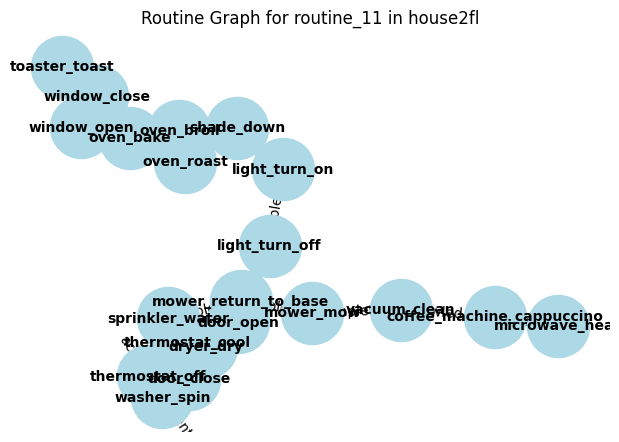

Routine for device: routine_12
['dishwasher_rinse', 'dishwasher_dry', 'microwave_heat', 'oven_bake', 'mower_return_to_base', 'mower_mow', 'thermostat_cool', 'thermostat_heat', 'thermostat_off', 'shade_up', 'shade_down', 'vacuum_clean', 'vacuum_return_to_base']


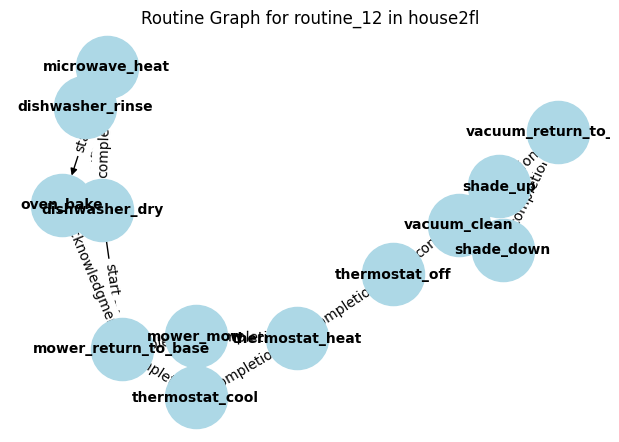

Routine for device: routine_13
['vacuum_clean', 'vacuum_return_to_base', 'light_turn_on', 'washer_rinse', 'washer_wash', 'dishwasher_dry', 'coffee_machine_mocha', 'dryer_dry', 'shade_up', 'shade_down', 'mower_return_to_base', 'mower_mow', 'toaster_toast', 'thermostat_off', 'thermostat_cool', 'thermostat_heat', 'window_open', 'window_close', 'sprinkler_water', 'microwave_heat', 'oven_broil', 'oven_roast', 'oven_bake', 'door_open', 'door_close']


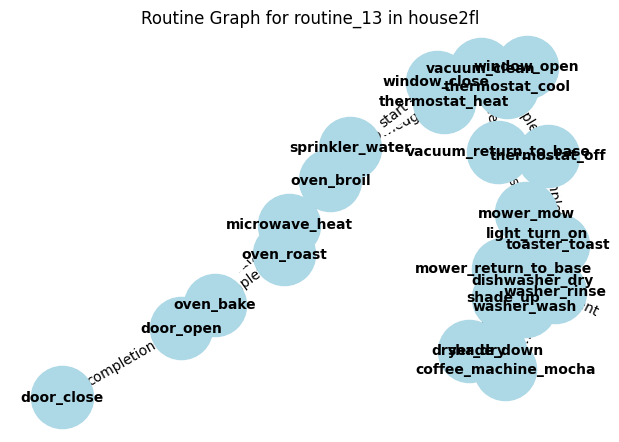

Routine for device: routine_14
['microwave_heat']


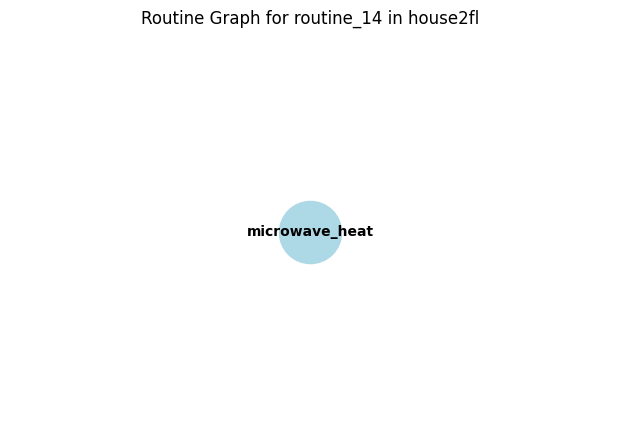

Routine for device: routine_15
['shade_down', 'oven_roast', 'oven_bake', 'mower_mow', 'mower_return_to_base']


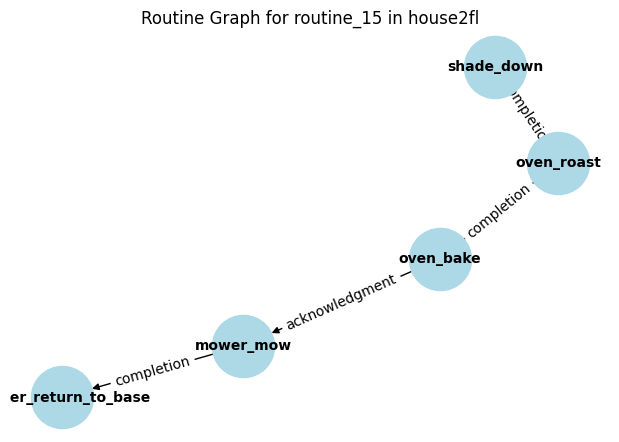

Routine for device: routine_16
['thermostat_cool', 'thermostat_heat', 'dishwasher_dry', 'dishwasher_wash', 'sprinkler_water', 'dryer_dry', 'toaster_toast', 'shade_up', 'oven_bake', 'oven_roast', 'window_close', 'coffee_machine_americano', 'door_open', 'washer_spin', 'washer_rinse', 'washer_wash', 'microwave_heat', 'mower_return_to_base', 'vacuum_return_to_base', 'vacuum_clean', 'light_turn_on', 'light_turn_off']


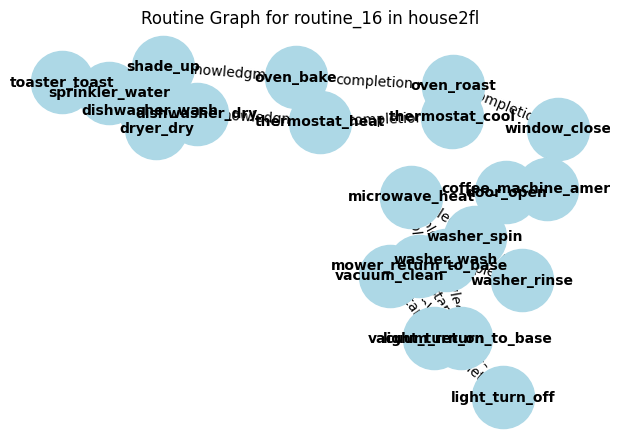

Routine for device: routine_17
['microwave_heat', 'coffee_machine_americano', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'dryer_dry', 'door_close']


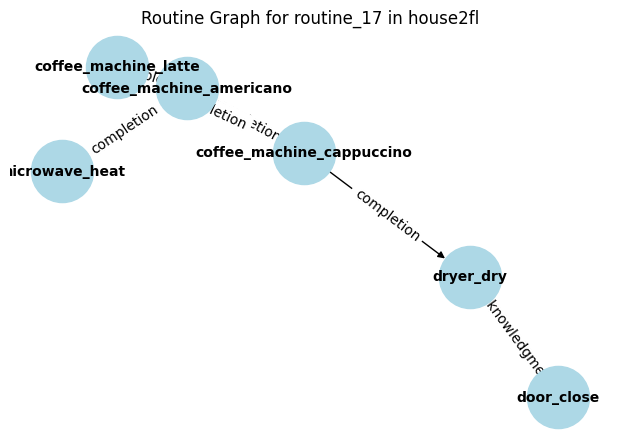

Routine for device: routine_18
['window_close', 'light_turn_off', 'sprinkler_water', 'toaster_toast', 'door_open', 'door_close', 'dishwasher_dry', 'mower_mow', 'mower_return_to_base', 'washer_spin', 'washer_wash', 'washer_rinse', 'coffee_machine_mocha', 'coffee_machine_latte', 'vacuum_clean', 'microwave_heat', 'shade_up']


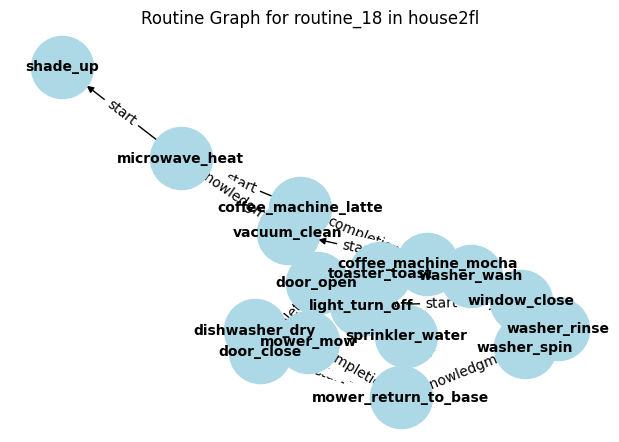

Routine for device: routine_19
['light_turn_on']


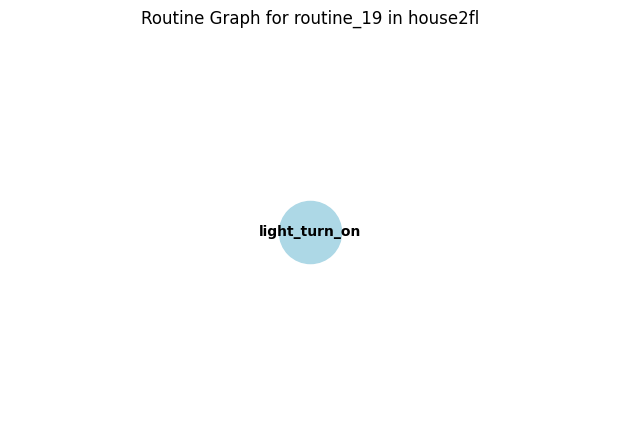

Routine for device: routine_20
['microwave_heat', 'window_close', 'window_open']


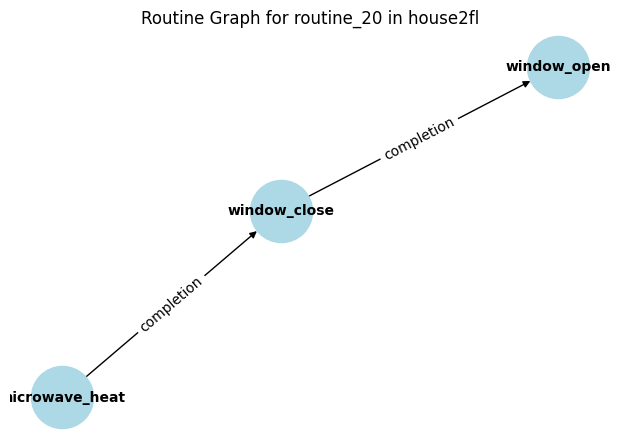

Routine for device: routine_21
['oven_broil', 'shade_down', 'shade_up', 'coffee_machine_espresso', 'toaster_toast', 'dryer_dry', 'light_turn_off', 'light_turn_on', 'microwave_heat']


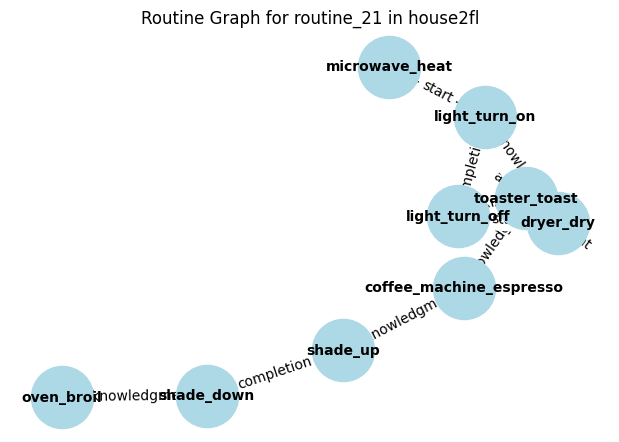

Routine for device: routine_22
['mower_return_to_base', 'coffee_machine_mocha', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_americano', 'vacuum_clean', 'toaster_toast', 'oven_broil', 'oven_roast', 'oven_bake', 'thermostat_cool', 'thermostat_heat', 'thermostat_off']


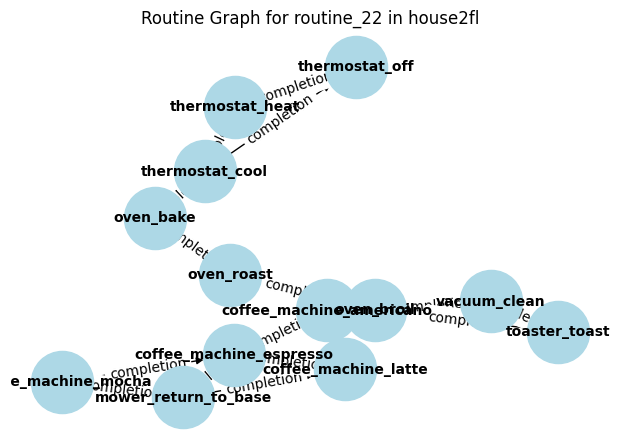

Routine for device: routine_23
['dryer_dry', 'oven_broil', 'oven_roast', 'oven_bake', 'light_turn_off', 'light_turn_on', 'thermostat_off', 'thermostat_heat', 'thermostat_cool', 'coffee_machine_mocha', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_latte', 'toaster_toast', 'washer_spin', 'washer_rinse', 'washer_wash', 'dishwasher_rinse', 'dishwasher_dry', 'dishwasher_wash', 'shade_up', 'shade_down', 'sprinkler_water', 'vacuum_clean', 'vacuum_return_to_base', 'door_open']


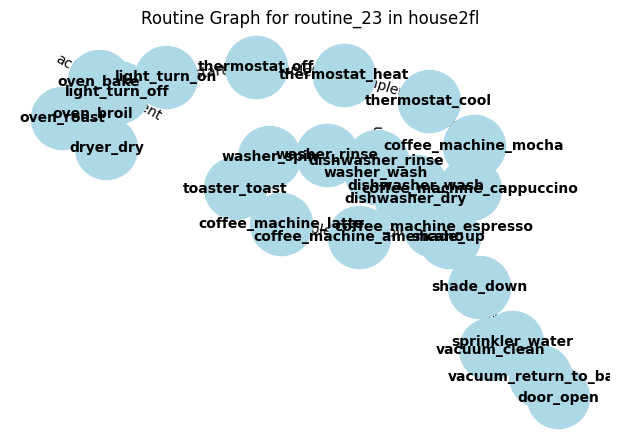

Routine for device: routine_24
['oven_bake']


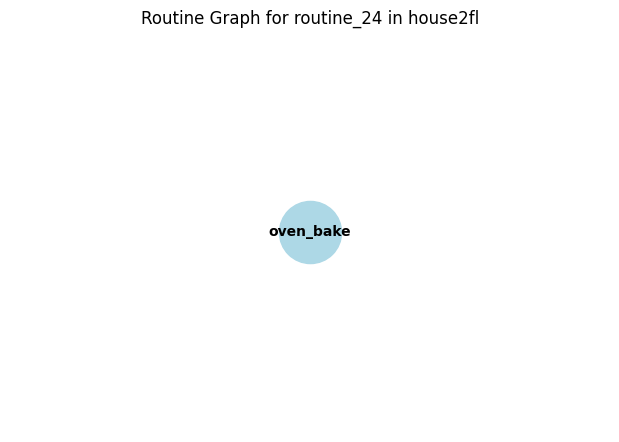

Routine for device: routine_25
['dryer_dry', 'mower_mow', 'washer_wash', 'oven_bake', 'oven_roast', 'oven_broil', 'light_turn_off', 'light_turn_on', 'dishwasher_dry', 'coffee_machine_americano', 'coffee_machine_espresso', 'coffee_machine_cappuccino', 'shade_up', 'shade_down']


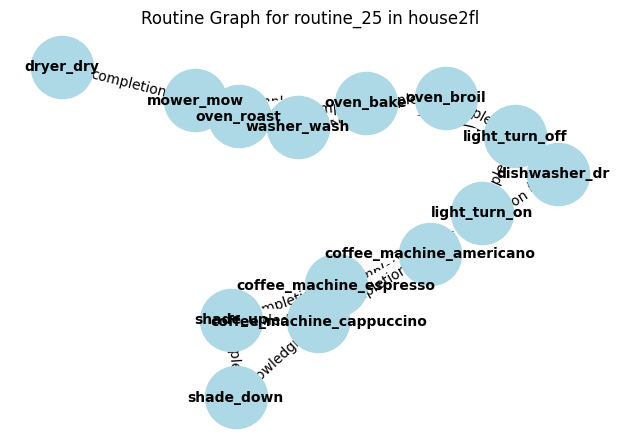

Routine for device: routine_26
['vacuum_clean', 'washer_wash', 'washer_spin', 'washer_rinse']


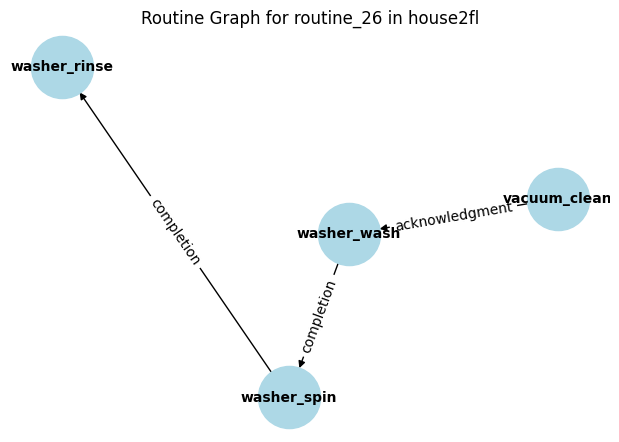

Routine for device: routine_27
['light_turn_off', 'light_turn_on', 'sprinkler_water', 'toaster_toast']


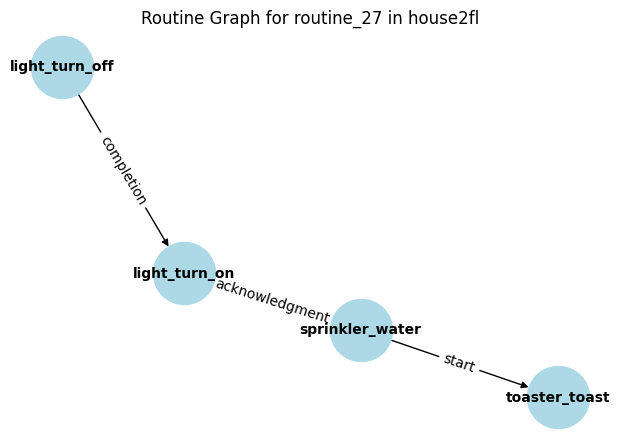

Routine for device: routine_28
['light_turn_off', 'door_open', 'door_close', 'microwave_heat', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_mocha', 'window_close', 'window_open', 'vacuum_return_to_base', 'vacuum_clean', 'oven_roast', 'oven_bake', 'sprinkler_water', 'thermostat_off', 'thermostat_heat', 'shade_down', 'mower_return_to_base', 'mower_mow', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'washer_wash', 'washer_rinse', 'dryer_dry', 'toaster_toast']


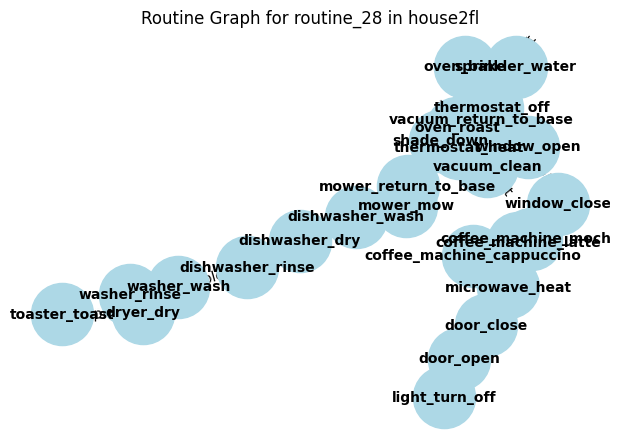

Routine for device: routine_29
['thermostat_off', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'coffee_machine_latte', 'shade_down', 'shade_up', 'light_turn_off', 'microwave_heat', 'vacuum_return_to_base', 'sprinkler_water', 'window_close', 'window_open', 'door_close', 'oven_broil', 'oven_roast', 'oven_bake', 'mower_return_to_base', 'mower_mow', 'washer_wash', 'washer_spin']


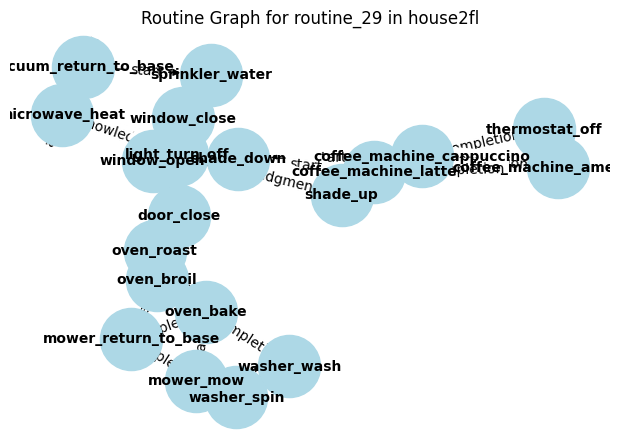

Routine for device: routine_30
['dishwasher_rinse', 'dishwasher_dry', 'dishwasher_wash', 'oven_roast', 'oven_broil', 'shade_down', 'thermostat_off', 'thermostat_cool', 'door_open', 'door_close', 'dryer_dry', 'toaster_toast', 'light_turn_on']


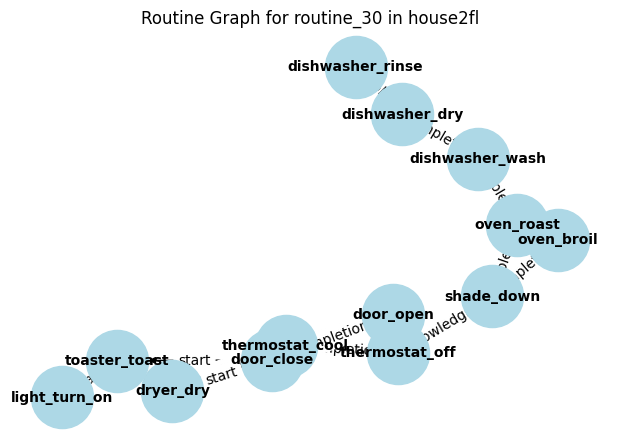

Routine for device: routine_31
['thermostat_off', 'thermostat_cool', 'toaster_toast', 'vacuum_return_to_base', 'dishwasher_wash', 'dishwasher_rinse', 'dishwasher_dry', 'coffee_machine_mocha', 'microwave_heat', 'mower_mow']


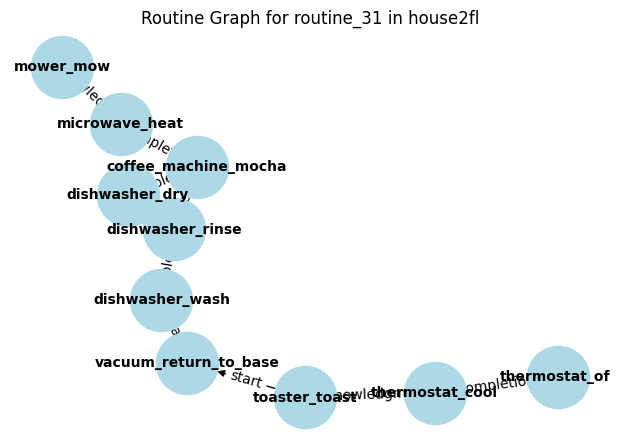

Routine for device: routine_32
['thermostat_off', 'thermostat_heat', 'thermostat_cool']


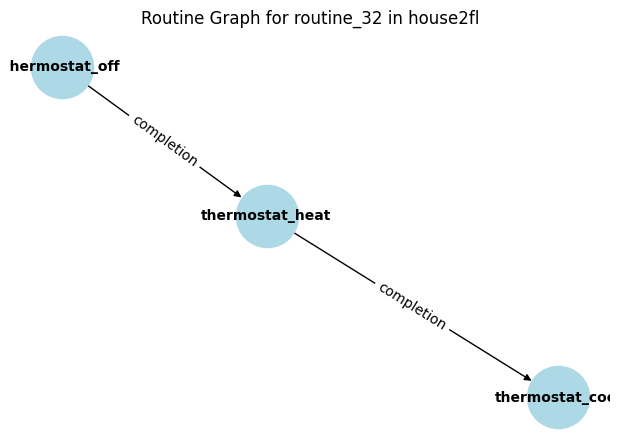

Routine for device: routine_33
['window_close', 'window_open', 'dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse', 'coffee_machine_cappuccino', 'vacuum_return_to_base', 'vacuum_clean', 'dryer_dry', 'light_turn_on', 'oven_bake', 'microwave_heat']


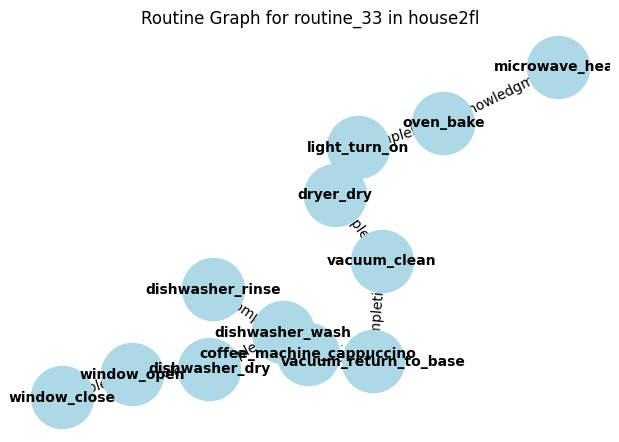

Routine for device: routine_34
['washer_spin', 'washer_rinse', 'washer_wash', 'light_turn_off', 'light_turn_on', 'shade_down', 'shade_up', 'vacuum_return_to_base', 'sprinkler_water', 'thermostat_heat']


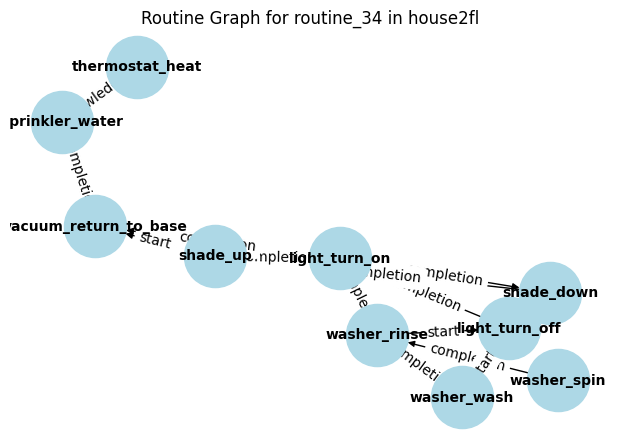

Routine for device: routine_35
['door_open', 'oven_broil', 'oven_bake', 'oven_roast', 'coffee_machine_mocha', 'thermostat_cool']


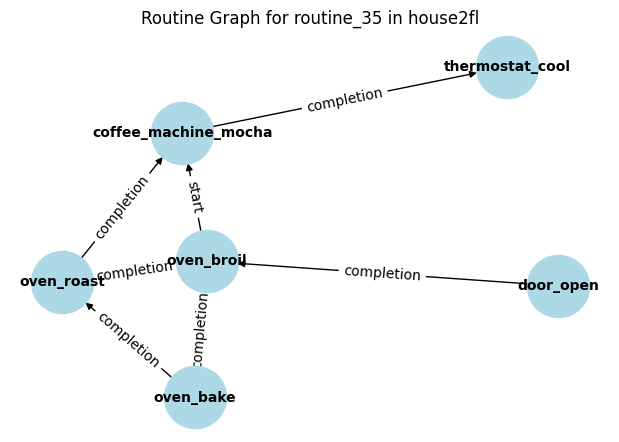

Routine for device: routine_36
['coffee_machine_cappuccino', 'coffee_machine_mocha', 'coffee_machine_latte', 'coffee_machine_americano', 'coffee_machine_espresso', 'toaster_toast', 'vacuum_clean', 'sprinkler_water', 'oven_broil', 'oven_bake', 'oven_roast', 'door_open', 'door_close', 'window_open', 'microwave_heat', 'mower_return_to_base', 'mower_mow', 'light_turn_off', 'light_turn_on', 'shade_down', 'washer_spin', 'washer_wash', 'washer_rinse']


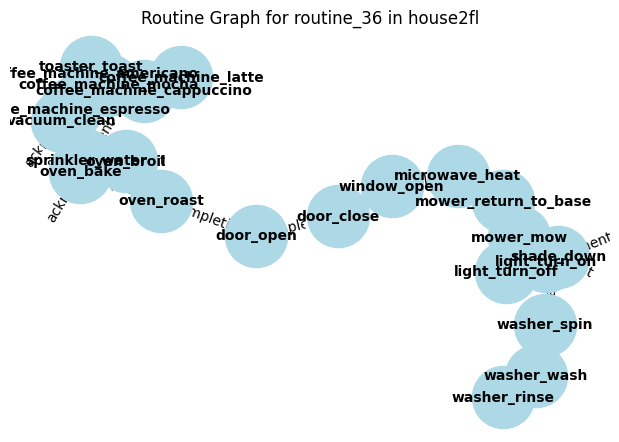

Routine for device: routine_37
['thermostat_cool', 'thermostat_off', 'dryer_dry', 'microwave_heat', 'sprinkler_water', 'vacuum_return_to_base', 'coffee_machine_espresso']


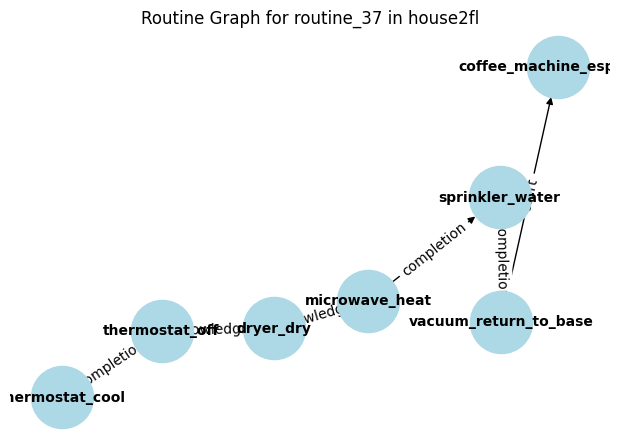

Routine for device: routine_38
['toaster_toast', 'mower_return_to_base', 'vacuum_clean', 'vacuum_return_to_base', 'shade_down', 'sprinkler_water', 'window_open', 'light_turn_off', 'light_turn_on', 'dishwasher_rinse', 'dishwasher_dry', 'oven_bake', 'oven_roast', 'oven_broil']


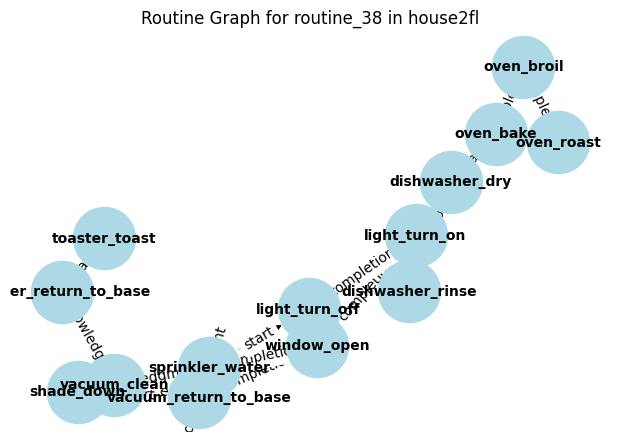

Routine for device: routine_39
['dryer_dry', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'door_open', 'door_close', 'mower_return_to_base']


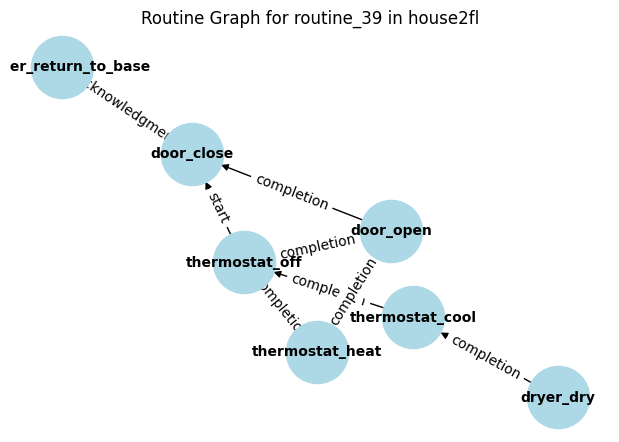

Routine for device: routine_40
['dishwasher_wash', 'dishwasher_rinse', 'microwave_heat', 'coffee_machine_cappuccino', 'window_close', 'window_open', 'washer_spin', 'thermostat_off', 'shade_up', 'shade_down', 'toaster_toast', 'dryer_dry', 'door_open', 'door_close', 'vacuum_return_to_base', 'vacuum_clean', 'light_turn_off', 'light_turn_on', 'mower_return_to_base', 'oven_roast', 'sprinkler_water']


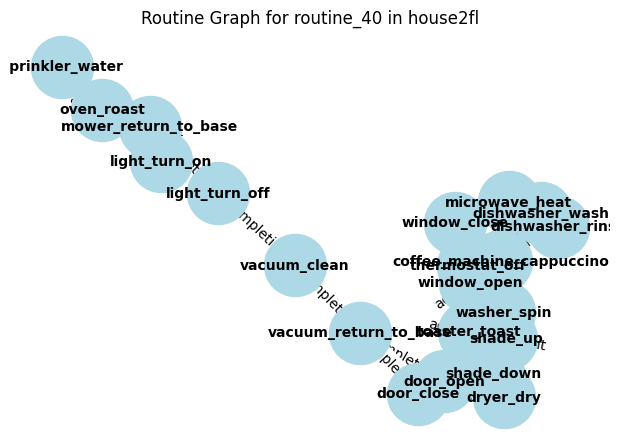

Routine for device: routine_41
['light_turn_off', 'thermostat_cool', 'thermostat_heat', 'oven_broil', 'oven_bake', 'oven_roast', 'washer_rinse', 'sprinkler_water', 'dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse', 'window_close', 'door_close', 'door_open']


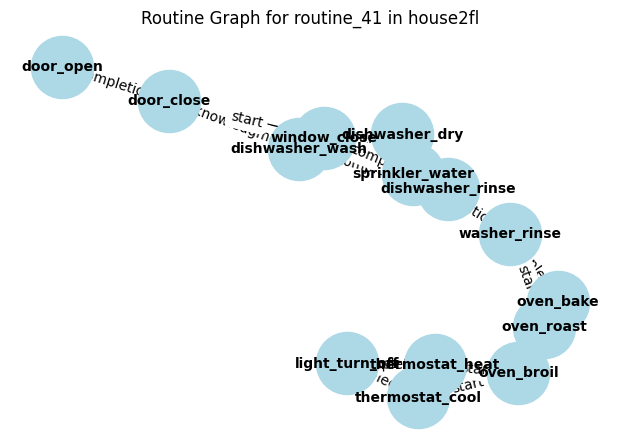

Routine for device: routine_42
['washer_spin', 'sprinkler_water', 'microwave_heat', 'door_close', 'dishwasher_dry', 'toaster_toast', 'light_turn_off', 'light_turn_on', 'oven_bake', 'oven_roast', 'oven_broil', 'mower_return_to_base', 'dryer_dry']


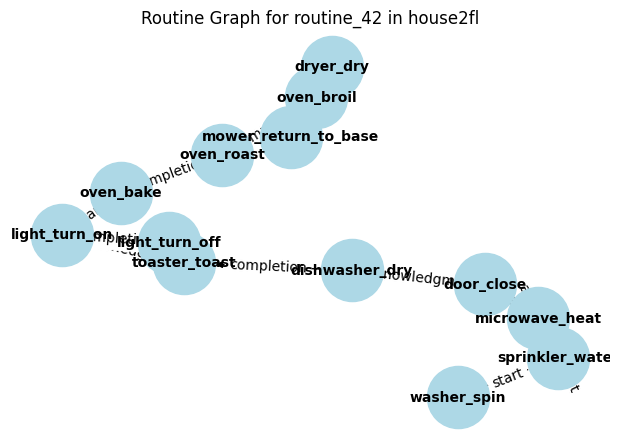

Routine for device: routine_43
['dishwasher_rinse', 'dishwasher_dry', 'door_open', 'thermostat_heat', 'thermostat_off', 'thermostat_cool', 'mower_return_to_base', 'mower_mow', 'toaster_toast', 'microwave_heat', 'window_open', 'window_close', 'vacuum_clean', 'oven_broil', 'oven_bake']


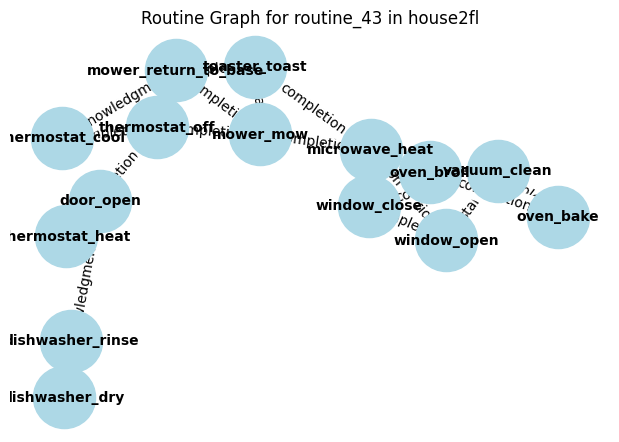

Routine for device: routine_44
['mower_mow', 'dryer_dry', 'shade_down', 'toaster_toast', 'dishwasher_wash', 'dishwasher_rinse', 'dishwasher_dry']


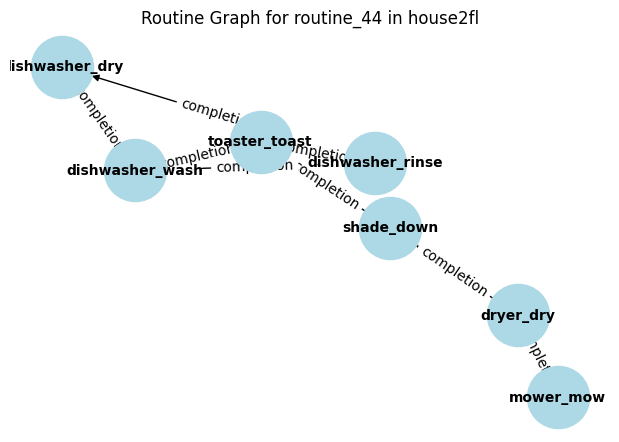

Routine for device: routine_45
['microwave_heat', 'mower_return_to_base', 'mower_mow', 'coffee_machine_cappuccino', 'coffee_machine_latte', 'coffee_machine_americano']


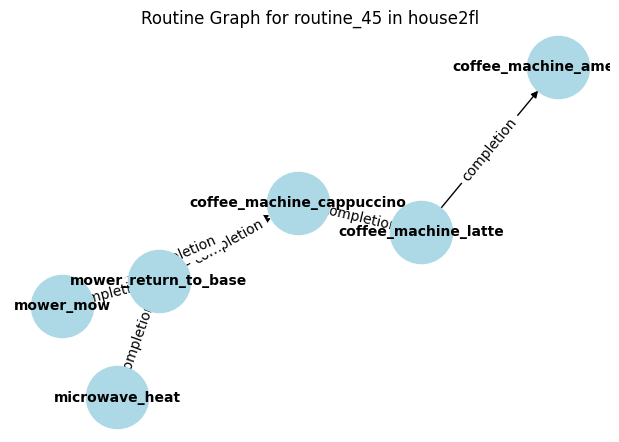

Routine for device: routine_46
['window_close', 'washer_rinse', 'washer_spin', 'light_turn_on', 'light_turn_off', 'sprinkler_water', 'oven_roast', 'shade_up', 'shade_down', 'dryer_dry', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_mocha', 'dishwasher_wash', 'thermostat_off', 'thermostat_heat']


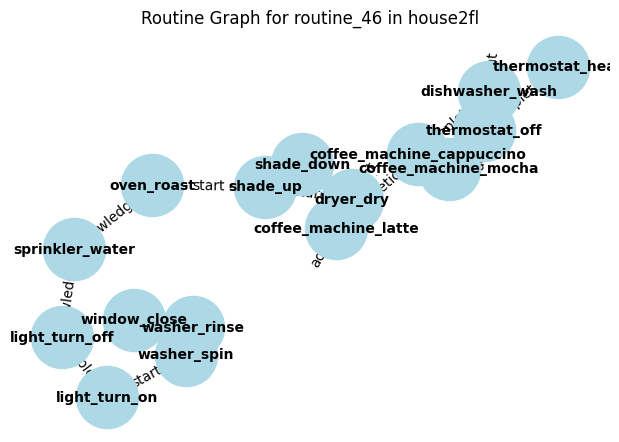

Routine for device: routine_47
['toaster_toast', 'window_open', 'washer_rinse', 'washer_spin', 'dryer_dry', 'light_turn_on', 'light_turn_off', 'thermostat_cool', 'thermostat_heat', 'thermostat_off', 'coffee_machine_espresso', 'coffee_machine_latte', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'mower_return_to_base']


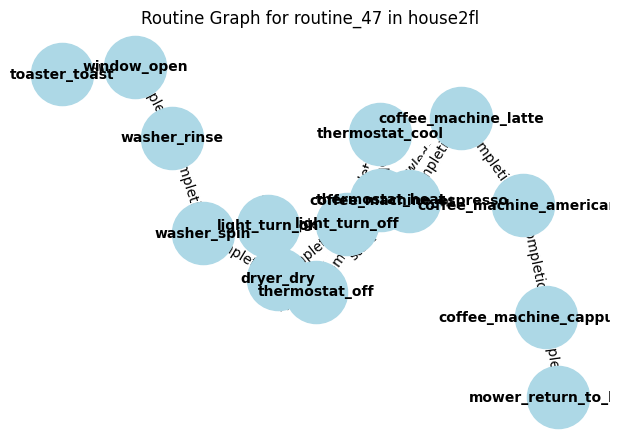

Routine for device: routine_48
['vacuum_return_to_base', 'vacuum_clean', 'sprinkler_water', 'toaster_toast', 'thermostat_off', 'thermostat_heat', 'coffee_machine_americano', 'oven_broil', 'oven_bake', 'washer_wash', 'washer_spin', 'light_turn_off', 'light_turn_on', 'mower_return_to_base', 'mower_mow', 'microwave_heat', 'door_open', 'dishwasher_dry', 'dishwasher_wash']


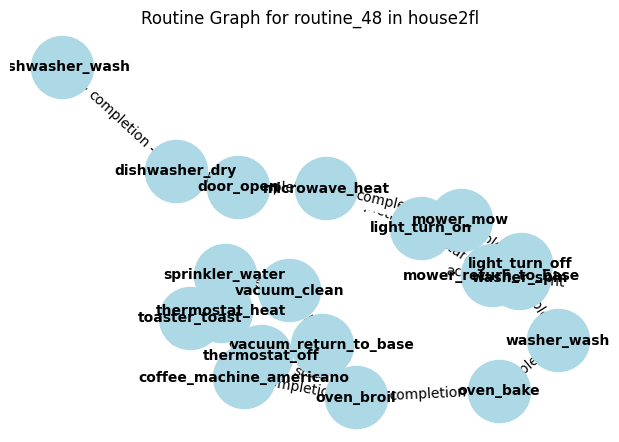

Routine for device: routine_49
['door_open', 'door_close', 'thermostat_heat', 'thermostat_off', 'thermostat_cool']


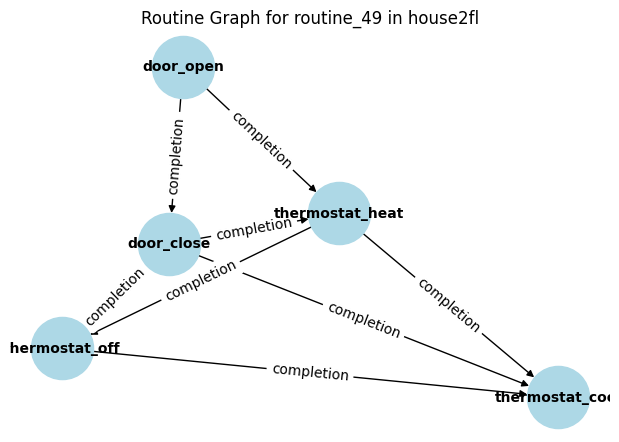

Routine for device: routine_50
['mower_mow', 'mower_return_to_base', 'microwave_heat', 'dishwasher_rinse', 'dishwasher_dry', 'oven_roast', 'oven_bake', 'oven_broil', 'toaster_toast', 'washer_wash', 'shade_down', 'shade_up']


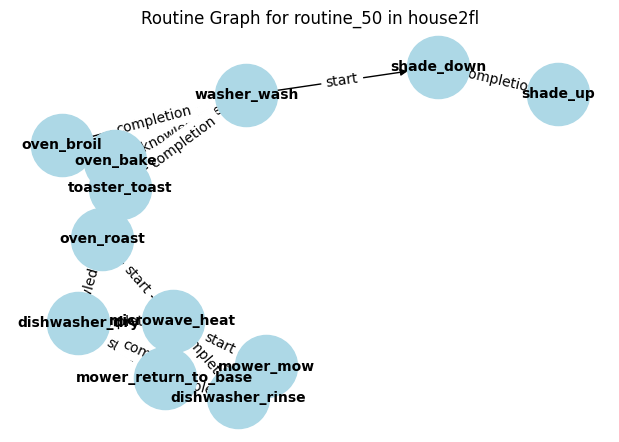

Routine for device: routine_51
['thermostat_cool', 'thermostat_heat', 'mower_return_to_base', 'mower_mow', 'oven_roast', 'oven_broil', 'vacuum_return_to_base', 'coffee_machine_latte', 'shade_up', 'shade_down']


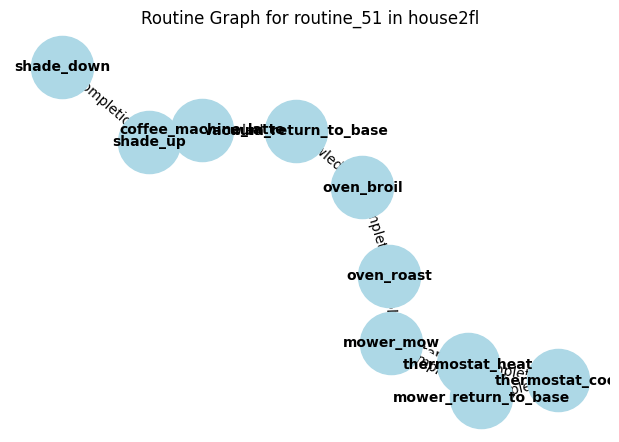

Routine for device: routine_52
['oven_bake', 'oven_roast', 'oven_broil', 'mower_mow', 'thermostat_heat', 'light_turn_off', 'sprinkler_water', 'shade_up', 'dishwasher_rinse', 'vacuum_clean']


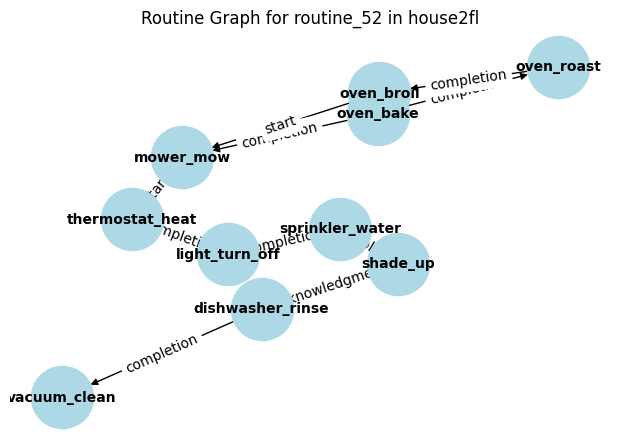

Routine for device: routine_53
['mower_return_to_base', 'coffee_machine_cappuccino', 'coffee_machine_americano', 'oven_broil', 'oven_bake', 'oven_roast', 'thermostat_cool', 'thermostat_off', 'dishwasher_dry', 'shade_down', 'sprinkler_water', 'light_turn_on', 'light_turn_off']


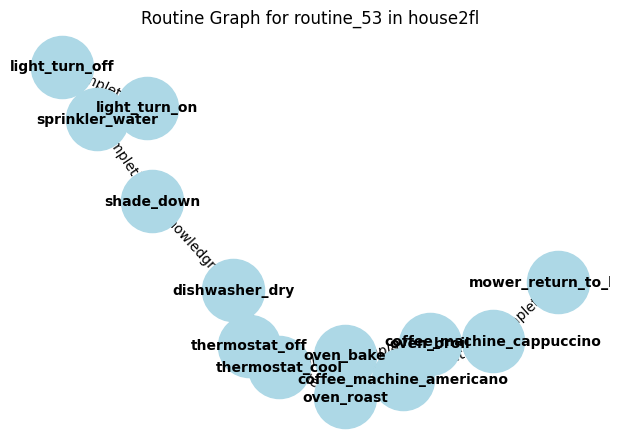

Routine for device: routine_54
['door_close', 'oven_broil', 'oven_bake', 'sprinkler_water', 'washer_rinse', 'washer_wash', 'dryer_dry']


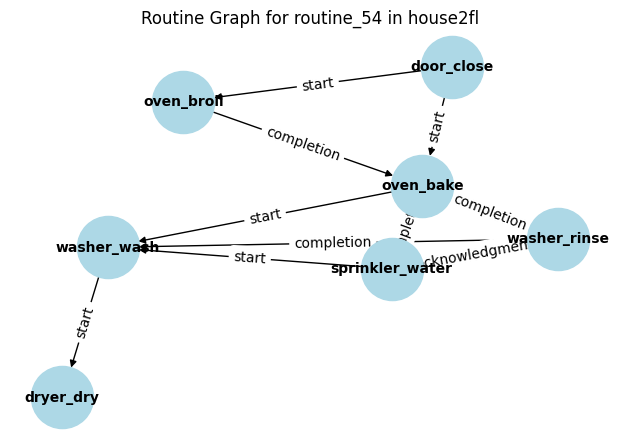

Routine for device: routine_55
['mower_return_to_base']


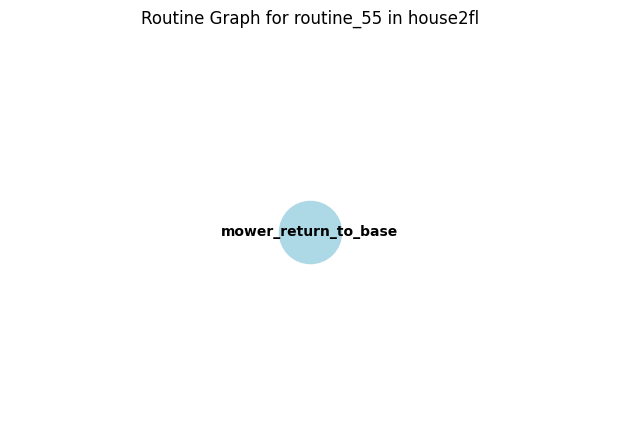

Routine for device: routine_56
['light_turn_off']


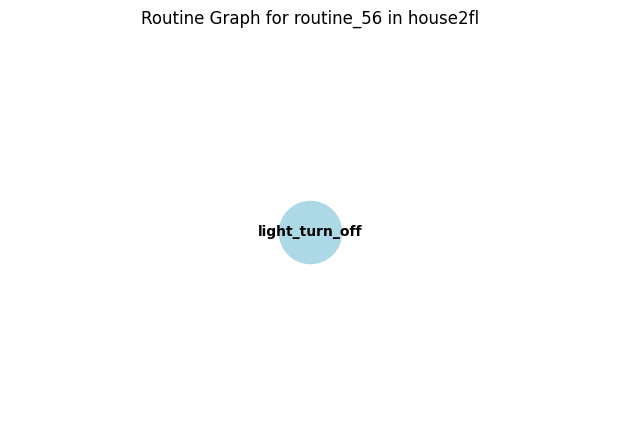

Routine for device: routine_57
['mower_return_to_base', 'mower_mow', 'sprinkler_water', 'washer_rinse', 'vacuum_return_to_base', 'vacuum_clean', 'toaster_toast', 'dryer_dry', 'dishwasher_rinse', 'dishwasher_dry', 'coffee_machine_latte', 'coffee_machine_americano', 'light_turn_off']


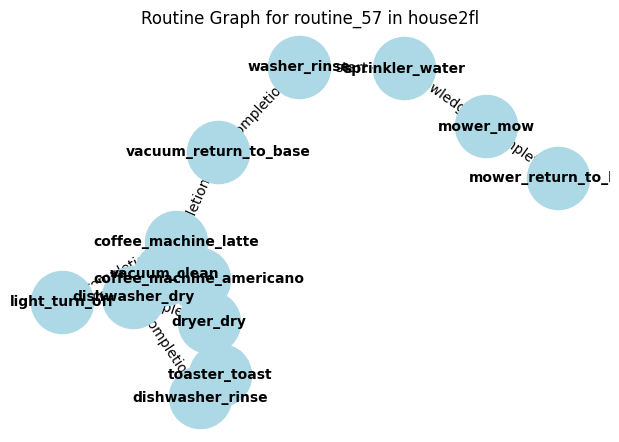

Routine for device: routine_58
['dishwasher_dry', 'dishwasher_wash', 'dishwasher_rinse']


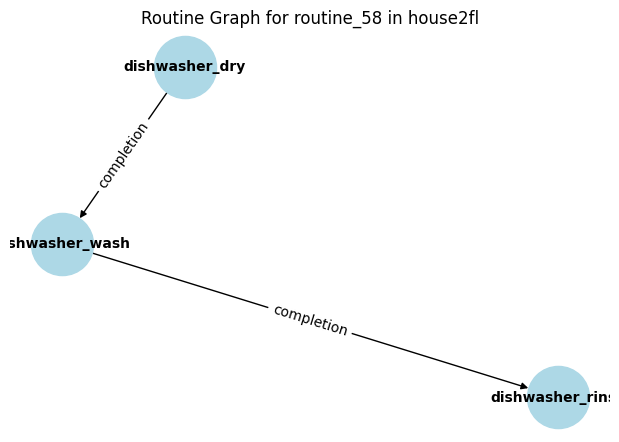

Routine for device: routine_59
['window_open', 'light_turn_on', 'light_turn_off', 'dryer_dry', 'toaster_toast', 'vacuum_clean', 'vacuum_return_to_base', 'mower_mow', 'mower_return_to_base', 'shade_down', 'shade_up', 'microwave_heat', 'dishwasher_rinse', 'coffee_machine_mocha', 'oven_bake', 'oven_roast', 'oven_broil', 'washer_spin', 'door_open', 'thermostat_heat', 'thermostat_cool', 'thermostat_off']


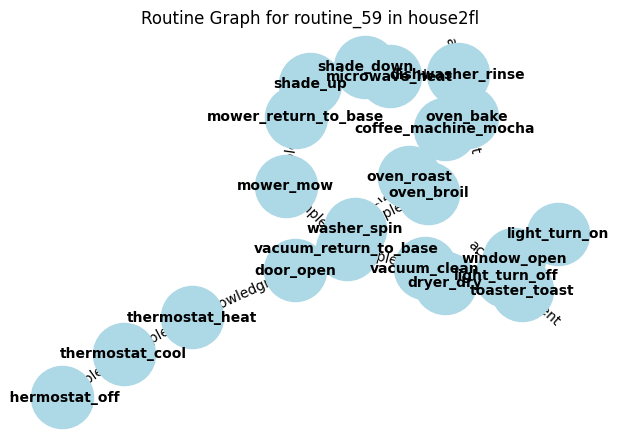

Routine for device: routine_60
['dryer_dry', 'washer_wash', 'washer_rinse', 'window_open', 'window_close', 'door_close', 'shade_up', 'shade_down', 'vacuum_clean', 'vacuum_return_to_base', 'light_turn_on', 'light_turn_off', 'sprinkler_water', 'mower_return_to_base', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'coffee_machine_espresso', 'coffee_machine_mocha', 'coffee_machine_latte', 'oven_broil', 'oven_bake', 'oven_roast', 'microwave_heat']


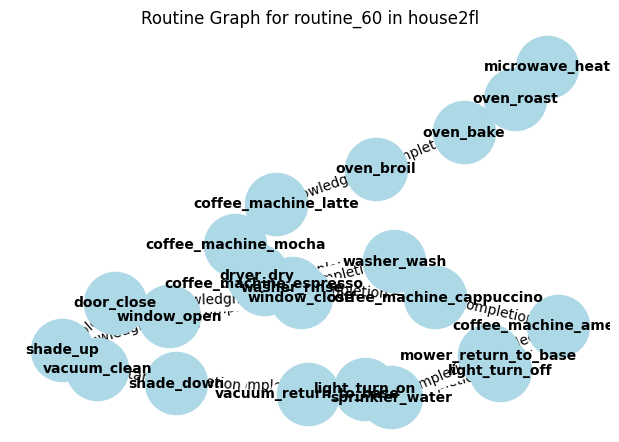

Routine for device: routine_61
['toaster_toast', 'washer_rinse', 'washer_spin', 'washer_wash']


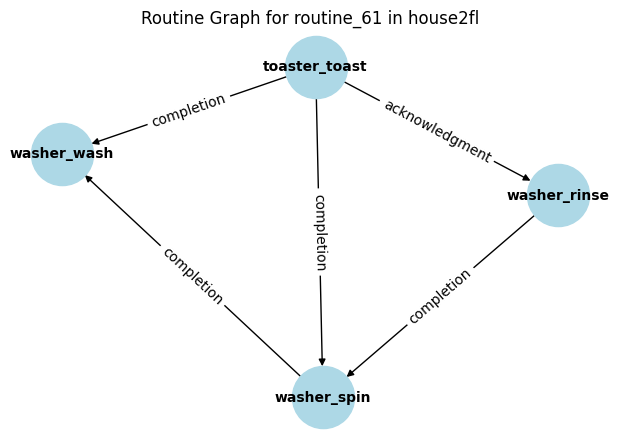

Routine for device: routine_62
['dishwasher_dry', 'shade_down', 'window_open', 'vacuum_clean', 'microwave_heat', 'thermostat_cool', 'thermostat_off', 'thermostat_heat', 'oven_bake', 'oven_broil', 'oven_roast']


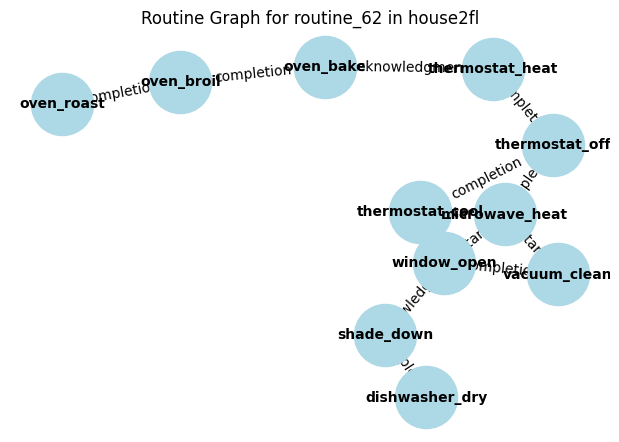

Routine for device: routine_63
['sprinkler_water', 'washer_spin', 'washer_wash', 'washer_rinse', 'vacuum_return_to_base', 'door_open', 'dryer_dry']


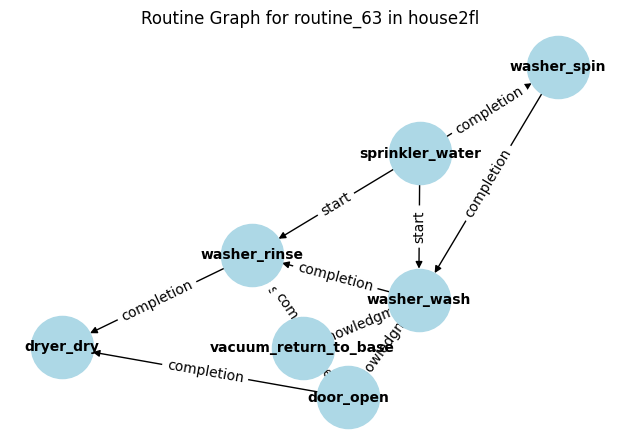

Routine for device: routine_64
['toaster_toast', 'shade_up', 'mower_mow', 'vacuum_clean', 'vacuum_return_to_base', 'thermostat_heat', 'thermostat_off']


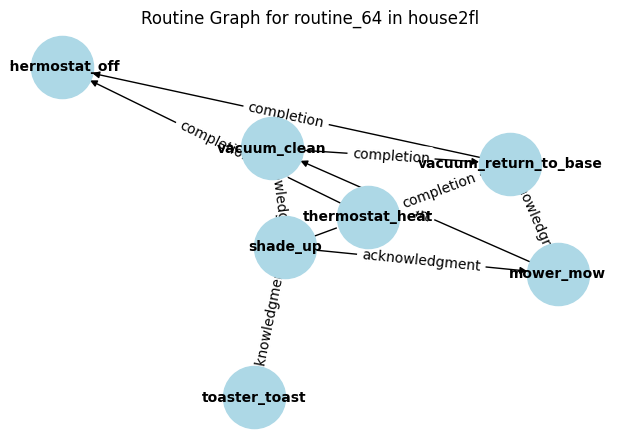

Routine for device: routine_65
['washer_rinse', 'washer_spin', 'washer_wash']


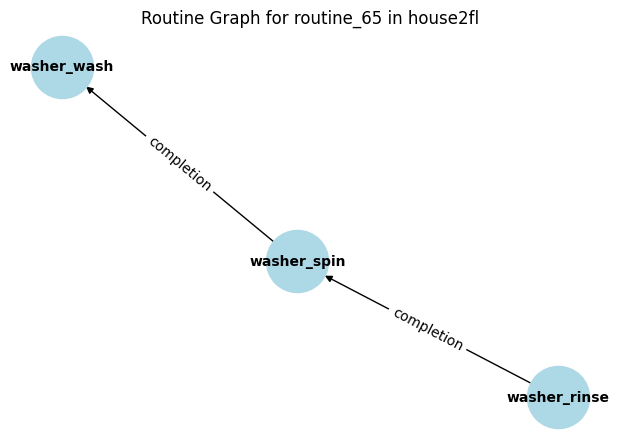

Routine for device: routine_66
['toaster_toast', 'mower_mow', 'vacuum_clean', 'vacuum_return_to_base', 'oven_roast', 'oven_broil', 'oven_bake', 'thermostat_off', 'thermostat_cool']


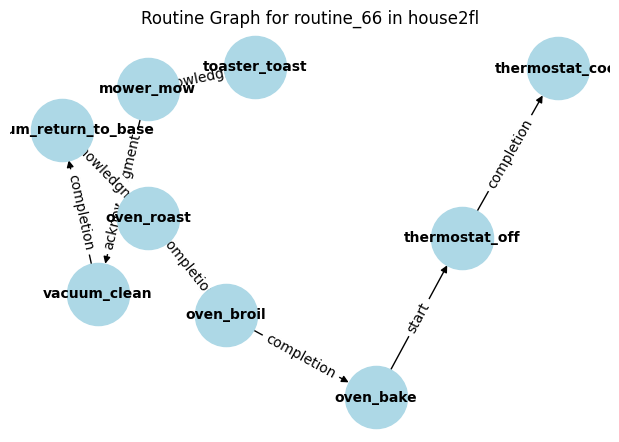

Routine for device: routine_67
['coffee_machine_latte', 'sprinkler_water', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'light_turn_off', 'oven_bake', 'oven_broil', 'oven_roast', 'toaster_toast', 'thermostat_cool', 'shade_down', 'washer_rinse', 'washer_wash', 'washer_spin', 'window_close', 'window_open', 'vacuum_clean', 'vacuum_return_to_base']


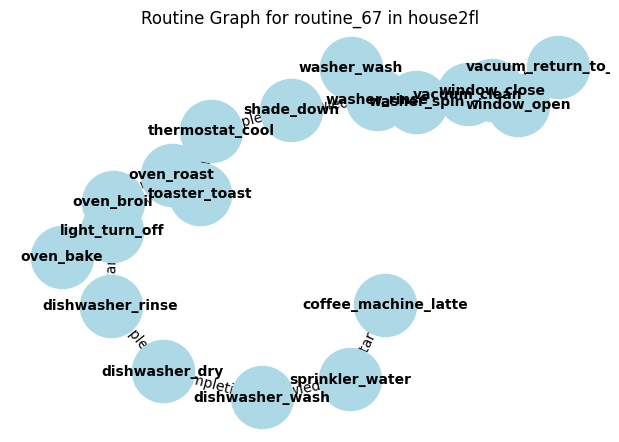

Routine for device: routine_68
['washer_wash', 'washer_spin', 'washer_rinse', 'vacuum_return_to_base', 'dishwasher_wash', 'dishwasher_dry', 'dryer_dry', 'oven_roast', 'oven_bake', 'oven_broil', 'light_turn_off', 'light_turn_on', 'coffee_machine_americano', 'coffee_machine_latte', 'coffee_machine_mocha', 'coffee_machine_espresso', 'thermostat_heat', 'thermostat_cool', 'thermostat_off', 'sprinkler_water', 'microwave_heat', 'window_close', 'window_open', 'door_open', 'door_close', 'shade_up', 'mower_return_to_base', 'mower_mow']


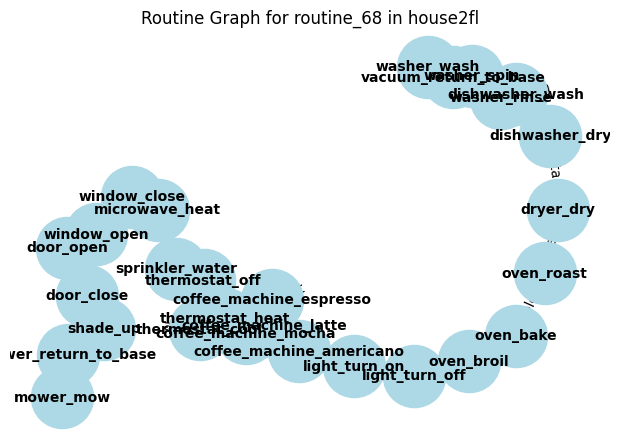

Routine for device: routine_69
['thermostat_off', 'thermostat_heat', 'thermostat_cool', 'light_turn_off', 'light_turn_on', 'washer_wash', 'washer_spin', 'washer_rinse', 'coffee_machine_americano', 'coffee_machine_mocha', 'coffee_machine_latte', 'coffee_machine_cappuccino', 'coffee_machine_espresso']


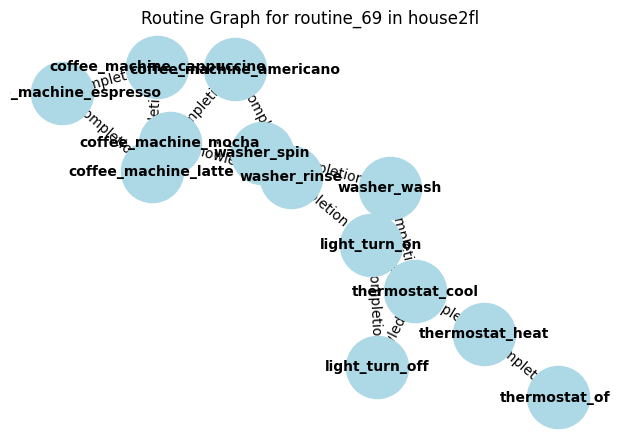

Routine for device: routine_70
['sprinkler_water', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_mocha', 'shade_down', 'shade_up', 'door_close', 'door_open', 'dryer_dry', 'light_turn_off', 'light_turn_on', 'dishwasher_dry', 'dishwasher_rinse', 'oven_roast', 'oven_bake', 'oven_broil', 'thermostat_heat', 'thermostat_off', 'mower_mow', 'mower_return_to_base']


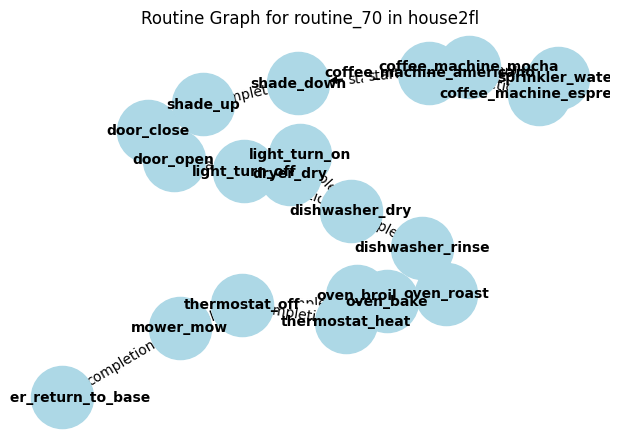

Routine for device: routine_71
['sprinkler_water', 'window_open', 'window_close', 'microwave_heat', 'dryer_dry', 'mower_mow', 'light_turn_off', 'light_turn_on', 'shade_up', 'shade_down', 'thermostat_cool', 'thermostat_heat', 'thermostat_off', 'washer_wash', 'washer_spin', 'dishwasher_wash', 'dishwasher_dry', 'dishwasher_rinse', 'coffee_machine_latte', 'coffee_machine_espresso', 'coffee_machine_americano', 'coffee_machine_cappuccino', 'oven_roast', 'vacuum_return_to_base', 'vacuum_clean', 'toaster_toast']


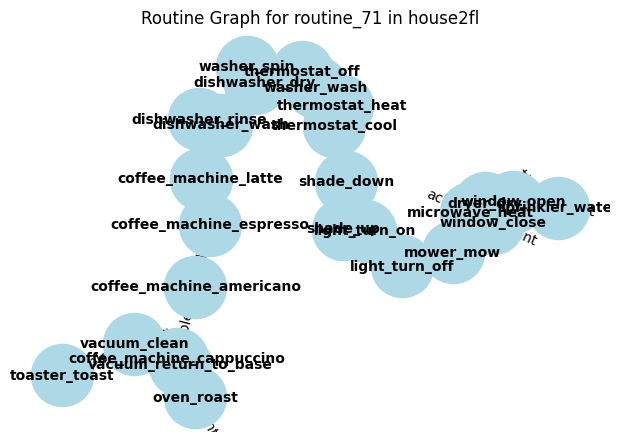

Routine for device: routine_72
['window_open', 'window_close', 'sprinkler_water', 'light_turn_on']


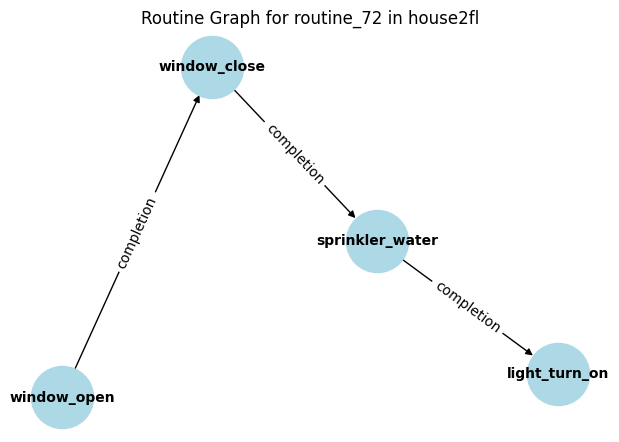

Routine for device: routine_73
['dryer_dry', 'light_turn_on', 'light_turn_off', 'coffee_machine_latte', 'coffee_machine_mocha', 'mower_return_to_base', 'mower_mow', 'microwave_heat', 'toaster_toast', 'sprinkler_water', 'shade_down']


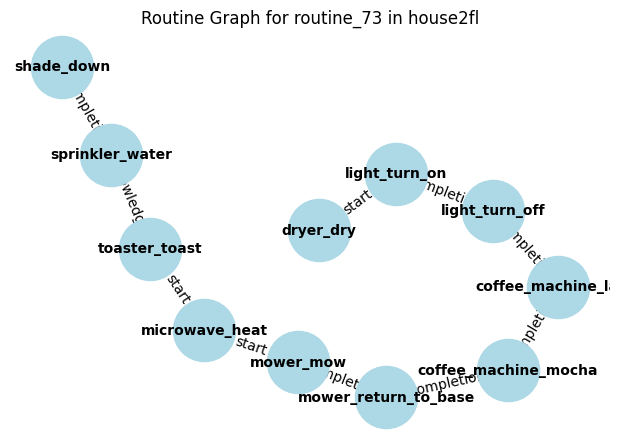

Routine for device: routine_74
['coffee_machine_mocha', 'coffee_machine_latte', 'dishwasher_wash', 'window_open', 'window_close', 'sprinkler_water', 'door_close', 'door_open', 'washer_wash', 'washer_rinse', 'washer_spin', 'vacuum_clean', 'vacuum_return_to_base', 'toaster_toast', 'oven_broil', 'oven_roast', 'mower_return_to_base']


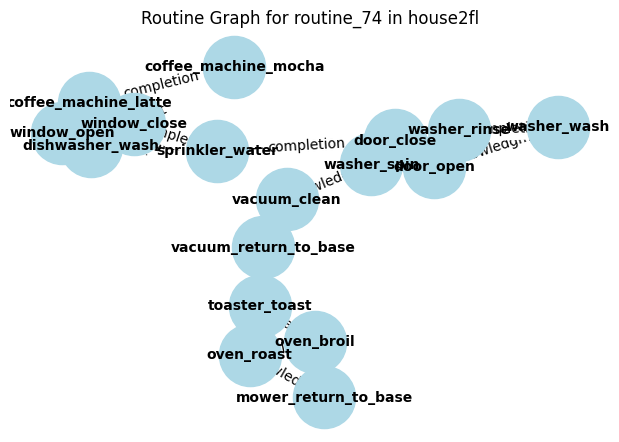

In [43]:
for space_name, routines in space_routines.items():
    print(f"Generated routines for {space_name}:")
    for device_name, routine_graph in routines.items():
        print(f"Routine for device: {device_name}")
        print(routine_graph.nodes())
        visualize_routine_graph(routine_graph, device_name, space_name)